In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import matplotlib
%matplotlib inline

from itertools import permutations
from math import sin, cos, pi, sqrt

from tqdm import tqdm

from scipy.io import loadmat
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
def parity_shell(values):
    values = list(values)
    N = len(values)
    num_swaps = 0
    for i in range(N-1):
        for j in range(i+1, N):
            if values[i] > values[j]:
                values[i], values[j] = values[j], values[i]
                num_swaps += 1
    return num_swaps % 2

def calculate_S_array(centre_list, r):
    S_arr = []

    x_r1 = np.array([r, 0, 0, 0.5*(r**2 - 1), 0.5*(r**2 + 1)])
    x_r2 = np.array([0, r, 0, 0.5*(r**2 - 1), 0.5*(r**2 + 1)])
    x_r3 = np.array([0, 0, r, 0.5*(r**2 - 1), 0.5*(r**2 + 1)])
    x_r4 = np.array([-r, 0, 0, 0.5*(r**2 - 1), 0.5*(r**2 + 1)])

    for x_c, y_c, z_c in centre_list:
        dist_sq = x_c**2 + y_c**2 + z_c**2
        #dist_sq = 1
        x_center = np.array([x_c, y_c, z_c, 0.5*(dist_sq - 1), 0.5*(dist_sq + 1)])

        x_1 = x_center + x_r1
        x_2 = x_center + x_r2
        x_3 = x_center + x_r3
        x_4 = x_center + x_r4

        S = np.array([0, 0, 0, 0, 0])
        res1 = 0
        res2 = 0
        res3 = 0
        res4 = 0
        res5 = 0
        for perm in list(permutations([1, 2, 3, 4])):
            res1 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]
        for perm in list(permutations([0, 2, 3, 4])):
            res2 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]
        for perm in list(permutations([0, 1, 3, 4])):
            res3 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]
        for perm in list(permutations([0, 1, 2, 4])):
            res4 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]
        for perm in list(permutations([0, 1, 2, 3])):
            res5 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]

        S = np.array([res1, res2, res3, res4, res5])

        S_arr.append(S)

    return np.array(S_arr)

In [3]:
def A_default(u):
    A_default = np.zeros((u, u))
    for i in range(u):
        for j in range(u):
            if i < j:
                A_default[i][j] = 1
    return A_default

def calculate_hyperfield_V(data, m, prediction_window = 10, u = 10, r = 0.1, A = 'default', extend = False):
    
    if A == 'default':
        A = np.zeros((u, u))
        for i in range(u):
            for j in range(u):
                if i < j:
                    A[i][j] = 1
    
    elif A == 'circular':
        A = np.zeros((u, u))
        for i in range(u):
            if i < u - 1:
                A[i][i+1] = 1
            else:
                A[i][0] = 1
    
    
    centre_list = []
    for k in range(u):
        centre_list.append((cos(2*pi*k/u), sin(2*pi*k/u), 0))
    
    S_array = calculate_S_array(centre_list, r)
    
    V_final_array = []
    
    if extend == True:
        l = list(data)
        l.extend([0]*u)
        data = np.array(l)
    
    for w in range(1, prediction_window + 1):
        
        V_array = []
        time_array = []
        
        if extend == False:
            modified_data = np.flip(data[np.arange(m + w, -1, -w)])
            original_index = np.flip(np.arange(len(data))[np.arange(m + w, -1, -w)])
        else:
            modified_data = np.flip(data[np.arange(m + 2*w, -1, -w)])
            original_index = np.flip(np.arange(len(data))[np.arange(m + 2*w, -1, -w)])
        
        for i in range(len(modified_data) - u):
            
            alpha = modified_data[i:(i+u)]
            Omega = np.array([alpha[i]*S_array[i] for i in range(u)])
            V_N = np.sum(Omega, axis = 0)
            V_AN = np.sum(np.array([[Omega[i]*Omega[j]*A[i][j] for j in range(u)] for i in range(u)]), axis = (0, 1, 2))
            V = np.hstack((V_N, V_AN))
            
            V_array.append(V)
            time_array.append(original_index[i+u])
        
        V_final_array.append((V_array, time_array))
        
    return V_final_array

In [4]:
def calculate_emergent_hyperfields_S(V_array, L_1 = 5, L_2 = 10):
    
    S_array = []
    
    for V_arr, _ in V_array:
        
        S_1_arr = [np.zeros((6,))]*L_1
        S_2_arr = [np.zeros((6,))]*(L_1 + 1)
        S_3_arr = [np.zeros((6,))]*L_2
        
        for i in range(L_1, len(V_arr)):
            S_1_arr.append(V_arr[i] - 1/L_1 * (np.sum(V_arr[(i - L_1):i], axis = 0)))
        for i in range(L_1 + 1, len(V_arr)):
            S_2_arr.append(S_1_arr[i] - S_1_arr[i - 1])
        for i in range(L_2, len(V_arr)):
            S_3_arr.append(V_arr[i] - 1/L_2 * (np.sum(V_arr[(i - L_2):i], axis = 0)))
            
        S_array.append((S_1_arr, S_2_arr, S_3_arr))
    
    return S_array

In [5]:
#eps = 10
#def target_func(data, index, w):
#    return (data[index] - data[index - w])/(data[index - w] + eps)

def target_func(data, index, w):
    return data[index]

def combine_hyperfields_for_single_series(data, V_array, S_array, L_1 = 5, L_2 = 10):
    
    L = max(L_1, L_2)
    
    train_test_data_features = []
    train_test_data_targets = []
    
    sizes = []
    
    validation_data_features = []
    validation_data_targets = []
    
    for i, arrs in enumerate(zip(V_array, S_array)):
        
        V_arr, S_arr = arrs
        w = i + 1
        features = []
        targets = []
        
        for j in range(L, len(V_arr[0]) - 1):
            features.append(np.array([np.sum(V_arr[0][j]),np.sum(S_arr[0][j]), np.sum(S_arr[1][j]), np.sum(S_arr[2][j])]))
            targets.append(target_func(data, V_arr[1][j], w))
        
        train_test_data_features.extend(features)
        train_test_data_targets.extend(targets)
        
        sizes.append(len(features))
        
        validation_data_features.append(np.array([np.sum(V_arr[0][-1]),np.sum(S_arr[0][-1]), np.sum(S_arr[1][-1]), \
                                                         np.sum(S_arr[2][-1])]))
        validation_data_targets.append(target_func(data, V_arr[1][-1], w))
    
    return (np.array(train_test_data_features), np.array(train_test_data_targets)), \
            (np.array(validation_data_features), np.array(validation_data_targets)), sizes



def combine_hyperfields_for_two_series(data_1, data_2, V_array_1, S_array_1, V_array_2, S_array_2, L_1 = 5, L_2 = 10):
    
    L = max(L_1, L_2)
    
    train_test_data_features = []
    train_test_data_targets = []
    
    sizes = []
    
    validation_data_features = []
    validation_data_targets = []
    
    for i, arrs in enumerate(zip(V_array_1, S_array_1, V_array_2, S_array_2)):
        
        V_arr_1, S_arr_1, V_arr_2, S_arr_2 = arrs
        w = i + 1
        features = []
        targets = []
        
        for j in range(L, len(V_arr_1[0]) - 1):
            features_list = []
            features_list += [np.sum(V_arr_1[0][j]),np.sum(S_arr_1[0][j]), np.sum(S_arr_1[1][j]), np.sum(S_arr_1[2][j])]
            features_list += [np.sum(V_arr_2[0][j]),np.sum(S_arr_2[0][j]), np.sum(S_arr_2[1][j]), np.sum(S_arr_2[2][j])]
            features_list += [np.sum(V_arr_2[0][j+1]),np.sum(S_arr_2[0][j+1]), np.sum(S_arr_2[1][j+1]), np.sum(S_arr_2[2][j+1])]
            features.append(np.array(features_list))
            targets.append(target_func(data_1, V_arr_1[1][j], w))
        
        train_test_data_features.extend(features)
        train_test_data_targets.extend(targets)
        
        sizes.append(len(features))
        
        validation_data_feature_list = [np.sum(V_arr_1[0][-1]),np.sum(S_arr_1[0][-1]), \
                                        np.sum(S_arr_1[1][-1]), np.sum(S_arr_1[2][-1])]
        validation_data_feature_list += [np.sum(V_arr_2[0][-2]),np.sum(S_arr_2[0][-2]), \
                                        np.sum(S_arr_2[1][-2]), np.sum(S_arr_2[2][-2])]
        validation_data_feature_list += [np.sum(V_arr_2[0][-1]),np.sum(S_arr_2[0][-1]), \
                                        np.sum(S_arr_2[1][-1]), np.sum(S_arr_2[2][-1])]
        
        
        validation_data_features.append(np.array(validation_data_feature_list))
        validation_data_targets.append(target_func(data_1, V_arr_1[1][-1], w))
    
    return (np.array(train_test_data_features), np.array(train_test_data_targets)), \
            (np.array(validation_data_features), np.array(validation_data_targets)), sizes

In [6]:
def generate_STON_based_dataset_for_single_series(data, m, prediction_window = 10, u = 10, r = 0.1, A = 'default', \
                                                  L_1 = 5, L_2 = 10):
    V_array = calculate_hyperfield_V(data = data, m = m, prediction_window = prediction_window, u = u, r = r, A = A)
    S_array = calculate_emergent_hyperfields_S(V_array = V_array, L_1 = L_1, L_2 = L_2)
    train_test_data, validation_data, sizes = combine_hyperfields_for_single_series(data = data, V_array = V_array, \
                                                                                    S_array = S_array, L_1 = L_1, L_2 = L_2)
    return train_test_data, validation_data, sizes


def generate_STON_based_dataset_for_two_series(data_1, data_2, m, prediction_window = 10, u = 10, r = 0.1, A = 'default', \
                                                  L_1 = 5, L_2 = 10):
    V_array_1 = calculate_hyperfield_V(data = data_1, m = m, prediction_window = prediction_window, u = u, r = r, A = A)
    S_array_1 = calculate_emergent_hyperfields_S(V_array = V_array_1, L_1 = L_1, L_2 = L_2)
    
    
    V_array_2 = calculate_hyperfield_V(data = data_2, m = m, prediction_window = prediction_window, u = u, r = r, A = A,\
                                       extend = True)
    S_array_2 = calculate_emergent_hyperfields_S(V_array = V_array_2, L_1 = L_1, L_2 = L_2)
    
    train_test_data, validation_data, sizes = combine_hyperfields_for_two_series(data_1, data_2, V_array_1, S_array_1, \
                                                                                 V_array_2, S_array_2, L_1 = L_1, L_2 = L_2)
    return train_test_data, validation_data, sizes

In [7]:
def visualize_hyperfields(train_test_data_features, sizes, w = 1, only_V = True, extended = False, save = False, u = 10):
    
    if w == 1:
        a = 0
        b = sizes[0]
    else:
        a = np.sum(sizes[:(w-2 + 1)])
        b = np.sum(sizes[:(w-1 + 1)])
        
    if only_V == True:
        fig, axes = plt.subplots(1, 1, figsize = (14, 12))
        axes.plot(train_test_data_features[a:b, 0])
        #axes[0][0].set_ylabel('$||V^{}||$'.format(w))
        axes.set_xticks([], [])
        axes.set_yticks([], [])
    
    elif extended == False:
        fig, axes = plt.subplots(2, 2, figsize = (20, 20))

        axes[0][0].plot(train_test_data_features[a:b, 0])
        axes[0][1].plot(train_test_data_features[a:b, 1])
        axes[1][0].plot(train_test_data_features[a:b, 2])
        axes[1][1].plot(train_test_data_features[a:b, 3])

        axes[0][0].set_ylabel('$||V^{}||$'.format(w))
        axes[0][1].set_ylabel('$||S^{}_1||$'.format(w))
        axes[1][0].set_ylabel('$||S^{}_2||$'.format(w))
        axes[1][1].set_ylabel('$||S^{}_3||$'.format(w))
    
    else:
        fig, axes = plt.subplots(4, 2, figsize = (20, 40))

        axes[0][0].plot(train_test_data_features[a:b, 0])
        axes[0][1].plot(train_test_data_features[a:b, 1])
        axes[1][0].plot(train_test_data_features[a:b, 2])
        axes[1][1].plot(train_test_data_features[a:b, 3])
        
        axes[2][0].plot(train_test_data_features[a:b, 4])
        axes[2][1].plot(train_test_data_features[a:b, 5])
        axes[3][0].plot(train_test_data_features[a:b, 6])
        axes[3][1].plot(train_test_data_features[a:b, 7])
        

        axes[0][0].set_ylabel('$||V^{}||$, ряд 1'.format(w))
        axes[0][1].set_ylabel('$||S^{}_1||$, ряд 1'.format(w))
        axes[1][0].set_ylabel('$||S^{}_2||$, ряд 1'.format(w))
        axes[1][1].set_ylabel('$||S^{}_3||$, ряд 1'.format(w))
        
        axes[2][0].set_ylabel('$||V^{}||$, ряд 2'.format(w))
        axes[2][1].set_ylabel('$||S^{}_1||$, ряд 2'.format(w))
        axes[3][0].set_ylabel('$||S^{}_2||$, ряд 2'.format(w))
        axes[3][1].set_ylabel('$||S^{}_3||$, ряд 2'.format(w))
        
    if save == True:
        _ = plt.savefig('V_{}.svg'.format(u))
    
    plt.show()

In [8]:
df = pd.read_csv("monthly_sunspots.csv")
df.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [9]:
raw_data = df['Sunspots'].to_numpy()
raw_data.shape

(2820,)

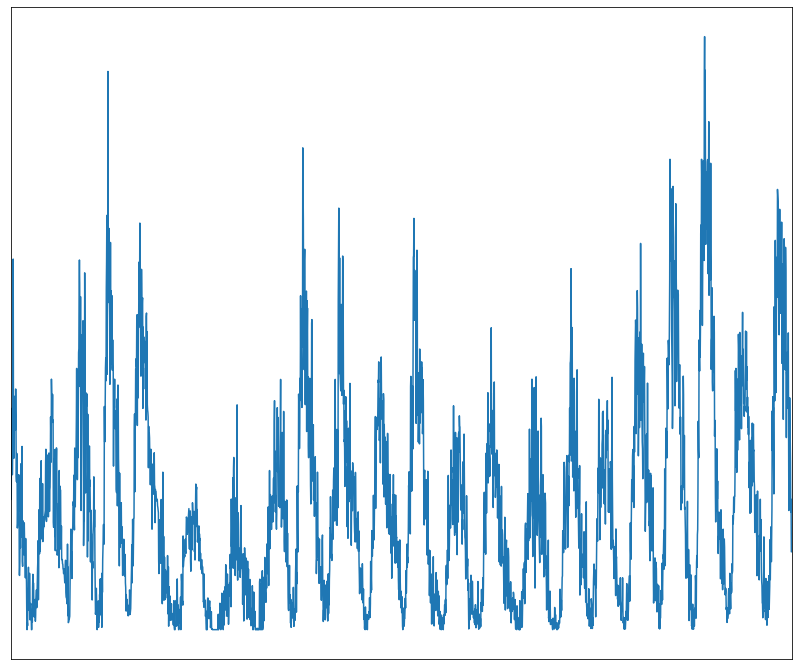

In [10]:
plt.figure(figsize = (14, 12))
plt.plot(raw_data)
#plt.title('Monthly Sunspots Dataset')
plt.xlim(1, 2820)
plt.xticks([],[])
plt.yticks([],[])

_ = plt.savefig('Ряд.svg')

plt.show()

In [11]:
m = 2809

In [12]:
#V_array = calculate_hyperfield_V(data = raw_data, m = m, prediction_window = 1, u = 10)

In [15]:
train_test_data, validation_data, sizes = generate_STON_based_dataset_for_single_series(raw_data, m = m, \
                                                                      prediction_window = 1, u = 50, r = 0.09)

<ipython-input-7-30986cfaa28c>:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes.set_xticks([], [])
<ipython-input-7-30986cfaa28c>:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes.set_yticks([], [])


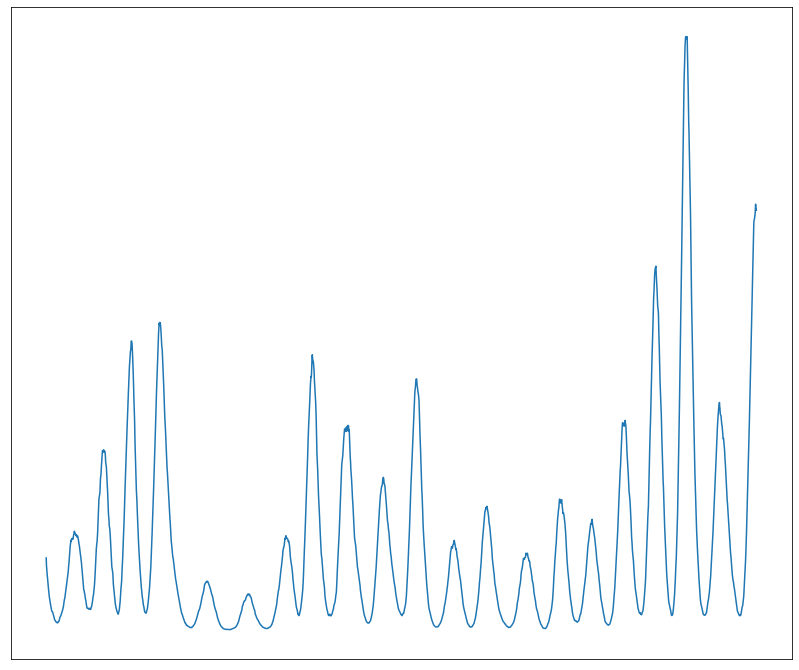

In [16]:
visualize_hyperfields(train_test_data[0], sizes, w = 1, save = True, u = 50)

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    

class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        # Stack some fully connected layers wirh relu activation.
        # Note that you do not have to add relu after the last fc layer
        
        model = []
        for i in range(len(hiddens)):
            if i == 0:
                model += [nn.Linear(input_shape, hiddens[i])]
            else:
                model += [nn.Linear(hiddens[i-1], hiddens[i])]
            model += [nn.ReLU()]
        
        model += [nn.Linear(hiddens[-1], output_shape)]
        self.net = nn.Sequential(*model)

    def forward(self, x):
        return self.net(x)

In [142]:
BATCH_SIZE = 4
EPOCHS = 25
LR = 10*1e-3

In [143]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    
device = torch.device(device)

In [144]:
device

device(type='cuda', index=0)

In [145]:
def train_epoch(model, train_loader, optimizer, loss, verbose = False):
    model.train()
    losses_array = []
    for batch in tqdm(train_loader, disable = not verbose):
        x, y = batch
        losses = loss(model(x.float().to(device)).flatten(), y.float().to(device))
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        losses_array.append(losses)
    return losses_array

def eval_model(model, test_loader, loss):
    model.eval()
    losses_array = []
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            losses = loss(model(x.float().to(device)).flatten(), y.float().to(device))
            losses_array.append(losses)
            
    return losses_array


def train_model(model, train_loader, test_loader, batch_size, epochs, lr, verbose = False, extra_verbose = False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    loss = nn.L1Loss()

    train_losses = []
    test_losses = []
    
    i = 1
    
    for epoch in tqdm(range(epochs), disable = verbose):
        train_loss = train_epoch(model, train_loader, optimizer, loss = loss, verbose = extra_verbose)
        test_loss = eval_model(model, test_loader, loss = loss)
        
        if (verbose == True):
            print('Epoch {}: Test loss = {}'.format(i, torch.Tensor(test_loss).mean().cpu().detach().numpy()))
        
        i += 1
        
        train_losses.append(torch.Tensor(train_loss).cpu().detach().numpy().mean())
        test_losses.append(torch.Tensor(test_loss).cpu().detach().numpy().mean())

    return np.array(train_losses), np.array(test_losses)

In [146]:
scaler = StandardScaler()
scaled_train_test_data = scaler.fit_transform(train_test_data[0])

train_test_dataset = TimeSeriesDataset(scaled_train_test_data, train_test_data[1])
#test_dataset = TimeSeriesDataset(test_data[0], test_data[1])

train_size = int(0.8 * len(train_test_dataset))
test_size = len(train_test_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_test_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

In [147]:
model = FullyConnectedMLP(4, [64, 128, 256, 128, 64], 1).to(device)
train_losses, test_losses = train_model(model, train_loader, test_loader, batch_size = BATCH_SIZE, epochs = EPOCHS, lr = LR, \
                                       verbose = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:50<00:00,  4.42s/it]


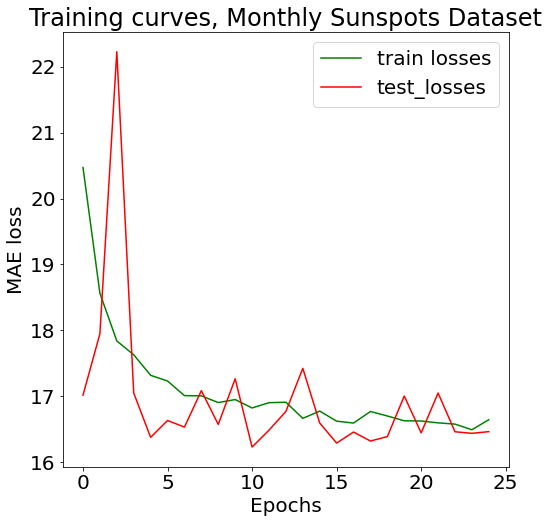

In [148]:
plt.figure(figsize = (8,8))

plt.plot(train_losses, label = 'train losses', color = 'green')
plt.plot(test_losses, label = 'test_losses', color = 'red')
plt.legend(loc = 'best')

plt.title('Training curves, Monthly Sunspots Dataset')

plt.xlabel('Epochs')
plt.ylabel('MAE loss')

plt.show()

In [31]:
def relative_to_abs(data, relative_prediction, m):
    return data[m]*(1 + relative_prediction + eps)

In [37]:
model.eval()
scaled_validation_data = scaler.transform(validation_data[0])
prediction_segment = torch.Tensor(scaled_validation_data).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()
#absolute_prediction = relative_to_abs(raw_data, relative_prediction, m = m).flatten()

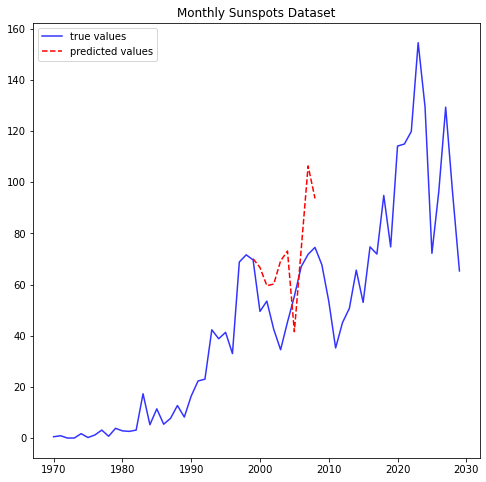

In [41]:
plt.figure(figsize = (8, 8))
plt.plot(np.arange(m+1-30, m+31), raw_data[(m+1-30): (m+31)], color = 'blue', alpha = 0.8, label = 'true values')
plt.plot(np.arange(m, m+10), absolute_prediction, '--', color = 'red', label = 'predicted values')
plt.title('Monthly Sunspots Dataset')

plt.legend(loc = 'best')
plt.show()

In [149]:
model.eval()
prediction_segment = torch.Tensor(scaled_train_test_data[:sizes[0]]).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()

scaled_validation_data = scaler.transform(validation_data[0])
val_prediction_segment = torch.Tensor(scaled_validation_data).to(device)
val_absolute_prediction = model(val_prediction_segment).cpu().detach().numpy()

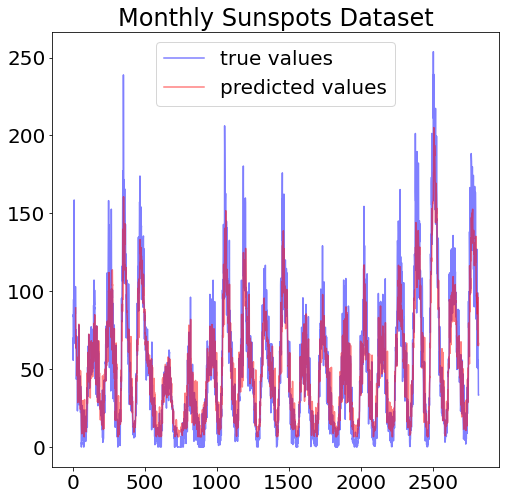

In [150]:
plt.figure(figsize = (8, 8))
plt.plot(raw_data, color = 'blue', label = 'true values', alpha = 0.5)
plt.plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
plt.plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
plt.title('Monthly Sunspots Dataset')

plt.legend(loc = 'best')
plt.show()

In [153]:
df_sync = pd.read_csv('occupancy_data/datatraining.csv')
df_sync.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [154]:
raw_data_sync = df_sync[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']].to_numpy()
raw_data_sync.shape

(8143, 5)

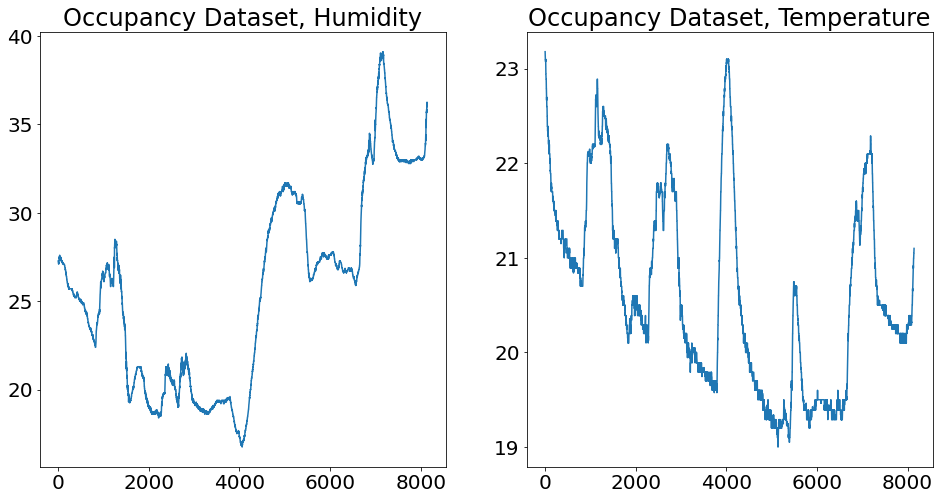

In [203]:
fig, axes = plt.subplots(1, 2, figsize = (16, 8))

axes[0].plot(raw_data_sync[:, 1])
axes[1].set_title('Occupancy Dataset, Temperature')
axes[1].plot(raw_data_sync[:, 0])
axes[0].set_title('Occupancy Dataset, Humidity')
plt.show()

In [179]:
sync_data_temp_hum = raw_data_sync[:, :2]
sync_data_temp = sync_data_temp_hum[:, 0]
sync_data_hum = sync_data_temp_hum[:, 1]

In [212]:
m = 8132
train_test_data, validation_data, sizes = generate_STON_based_dataset_for_single_series(sync_data_hum, m = m, \
                                                                      prediction_window = 10, u = 10, r = 0.09)

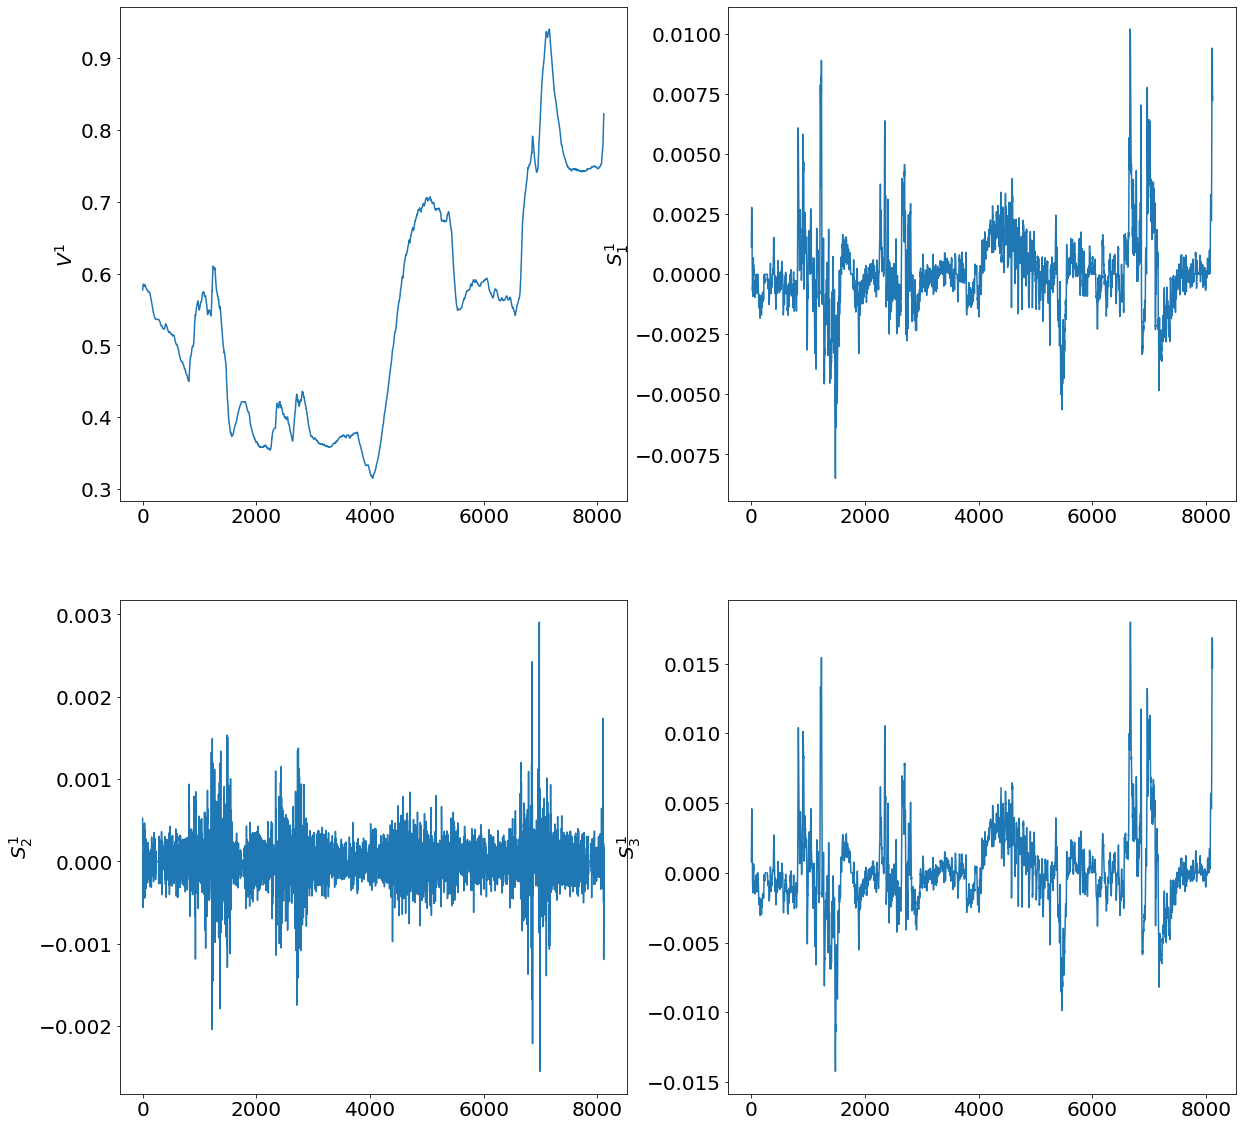

In [172]:
visualize_hyperfields(train_test_data[0], sizes, w = 1)

In [213]:
train_test_dataset = TimeSeriesDataset(train_test_data[0], train_test_data[1])

train_size = int(0.8 * len(train_test_dataset))
test_size = len(train_test_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_test_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

In [218]:
model = FullyConnectedMLP(4, [64, 128, 256, 128, 64], 1).to(device)
train_losses, test_losses = train_model(model, train_loader, test_loader, batch_size = BATCH_SIZE, epochs = EPOCHS, lr = LR, \
                                       verbose = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [05:27<00:00, 13.10s/it]


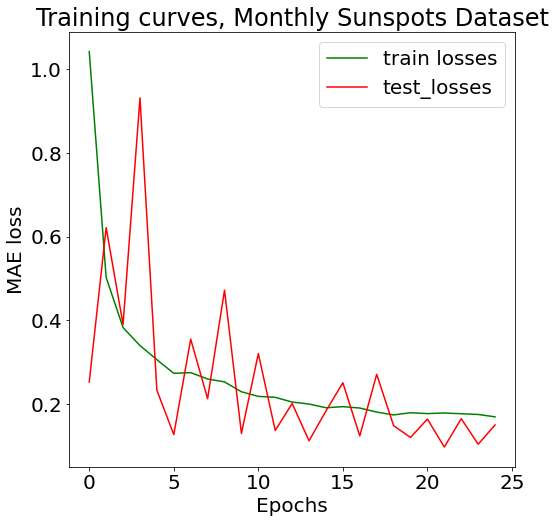

In [219]:
plt.figure(figsize = (8,8))

plt.plot(train_losses, label = 'train losses', color = 'green')
plt.plot(test_losses, label = 'test_losses', color = 'red')
plt.legend(loc = 'best')

plt.title('Training curves, Monthly Sunspots Dataset')

plt.xlabel('Epochs')
plt.ylabel('MAE loss')

plt.show()

In [221]:
model.eval()
prediction_segment = torch.Tensor(train_test_data[0][:sizes[0]]).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()

val_prediction_segment = torch.Tensor(validation_data[0]).to(device)
val_absolute_prediction = model(val_prediction_segment).cpu().detach().numpy()

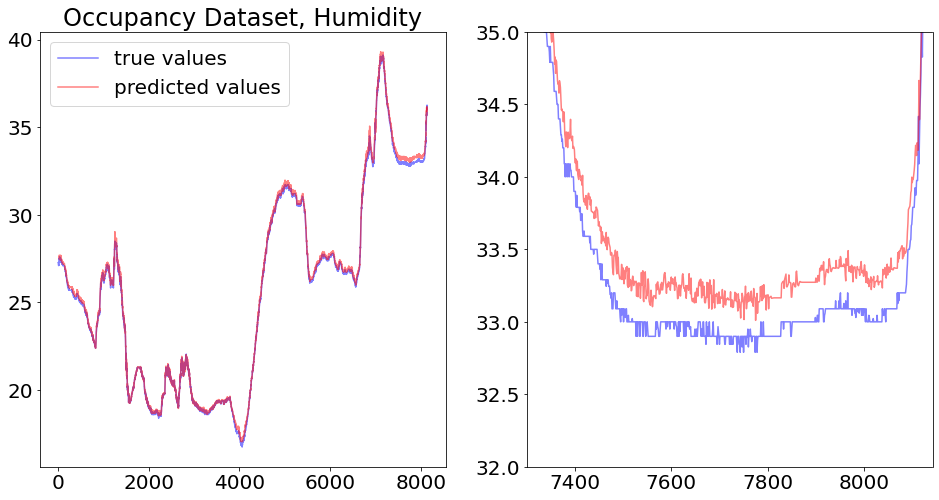

In [227]:
fig, axes = plt.subplots(1, 2, figsize = (16, 8))
axes[0].plot(sync_data_hum, color = 'blue', label = 'true values', alpha = 0.5)
axes[0].plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
axes[0].plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
axes[0].set_title('Occupancy Dataset, Humidity')
axes[0].legend(loc = 'best')


axes[1].plot(sync_data_hum, color = 'blue', label = 'true values', alpha = 0.5)
axes[1].plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
axes[1].plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
#axes[1].set_title('Occupancy Dataset, Humidity')
axes[0].legend(loc = 'best')
axes[1].set_ylim(32, 35)
axes[1].set_xlim(7300, 8142)
plt.show()

In [228]:
m = 8132
train_test_data, validation_data, sizes = generate_STON_based_dataset_for_two_series(sync_data_hum, sync_data_temp, m = m, \
                                                                      prediction_window = 10, u = 10, r = 0.09)

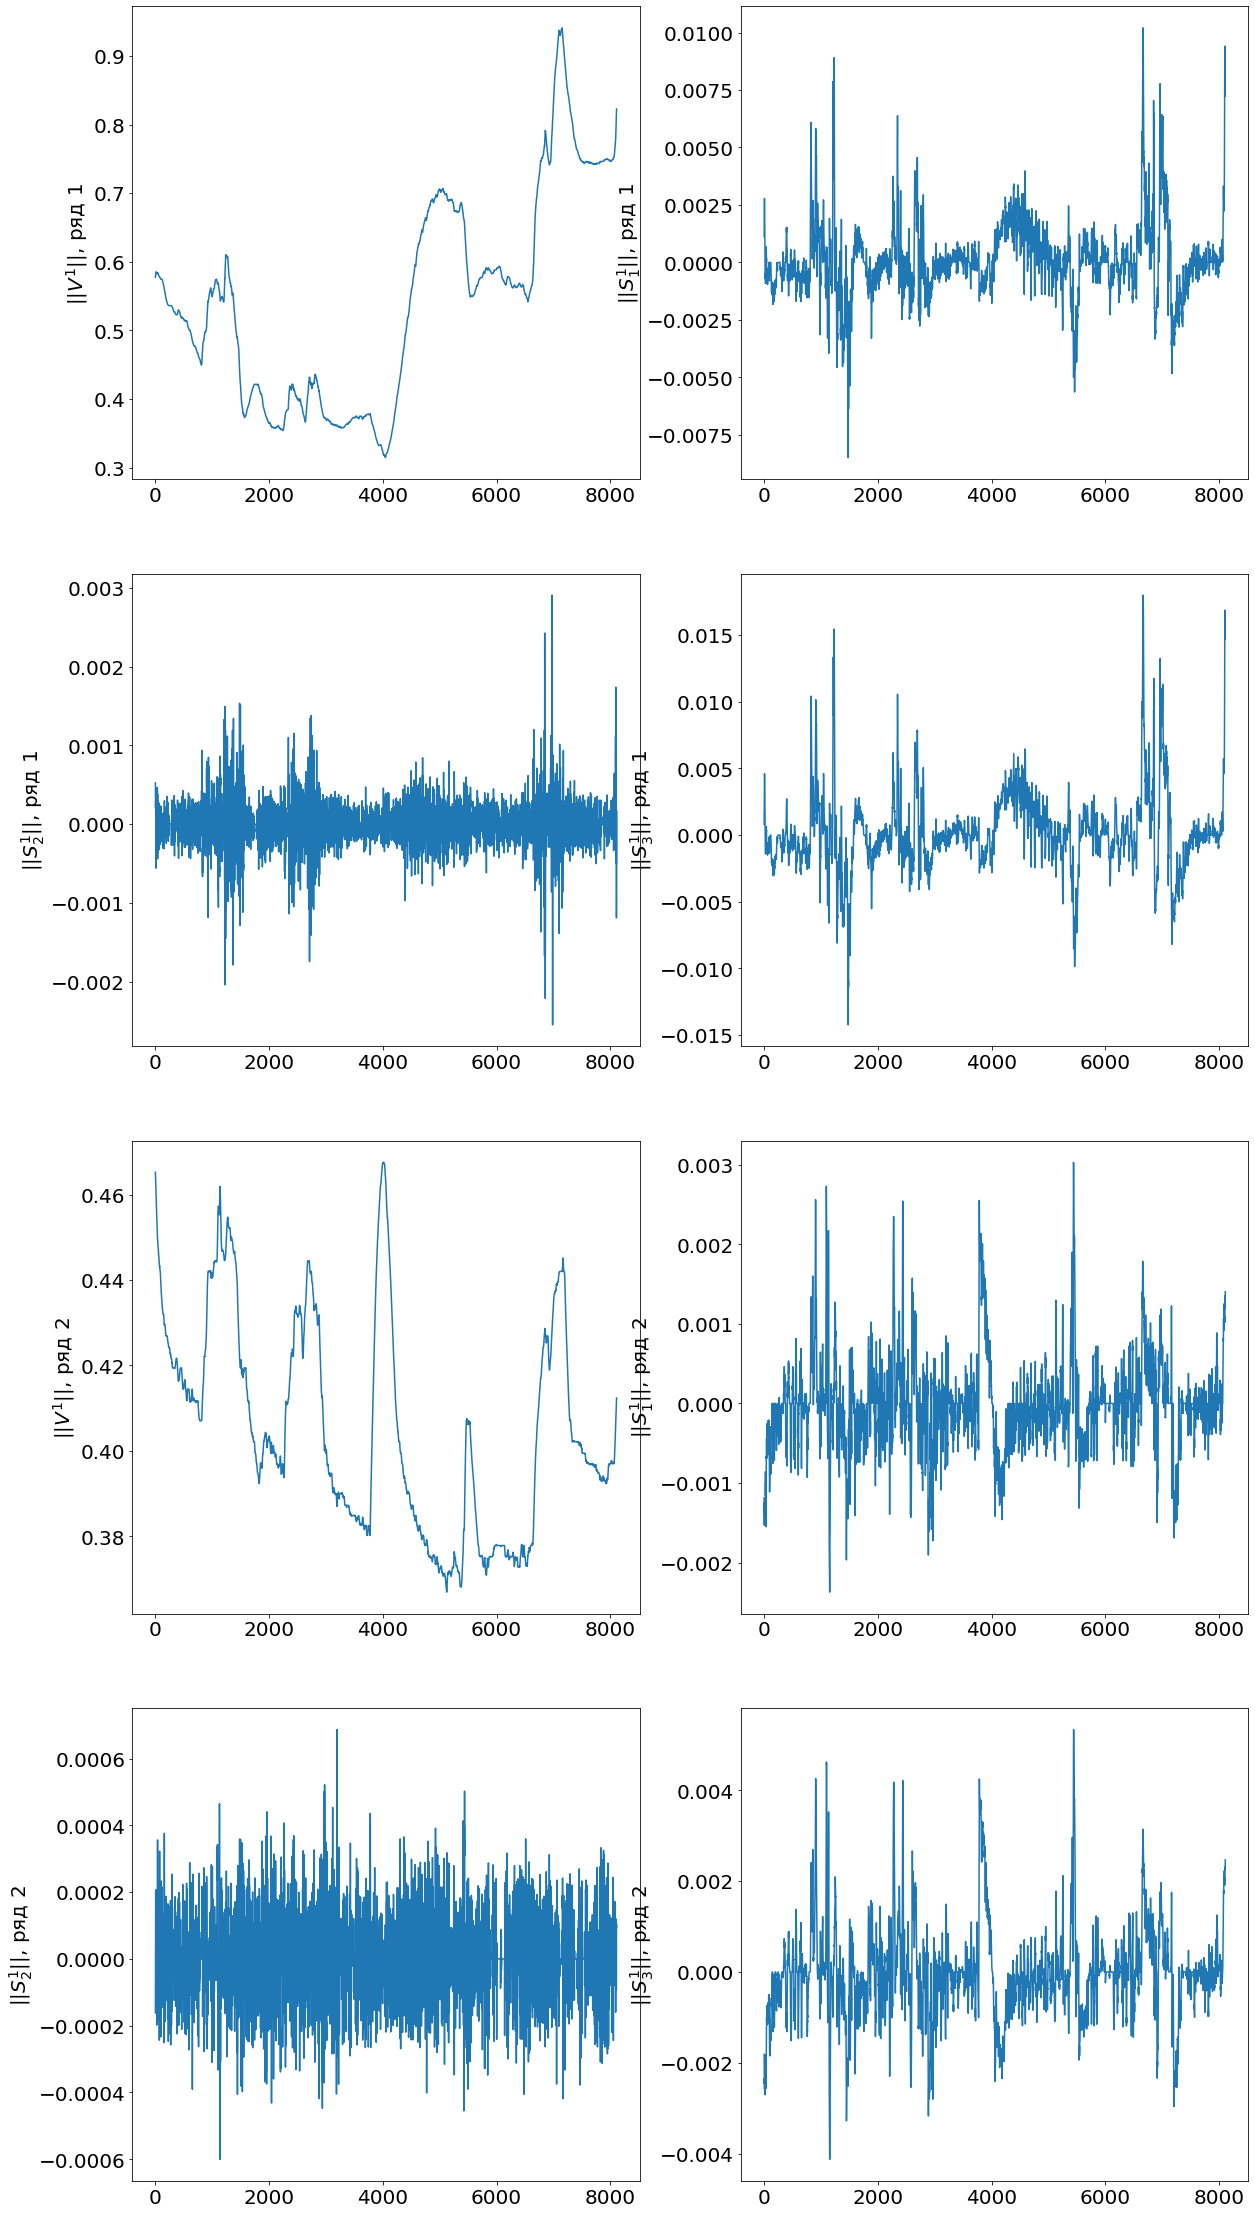

In [208]:
visualize_hyperfields(train_test_data[0], sizes, w = 1, extended = True)

In [229]:
train_test_dataset = TimeSeriesDataset(train_test_data[0], train_test_data[1])

train_size = int(0.8 * len(train_test_dataset))
test_size = len(train_test_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_test_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

model = FullyConnectedMLP(12, [64, 128, 256, 128, 64], 1).to(device)
train_losses, test_losses = train_model(model, train_loader, test_loader, batch_size = BATCH_SIZE, epochs = EPOCHS*2, lr = LR, \
                                       verbose = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:13<00:00, 13.46s/it]


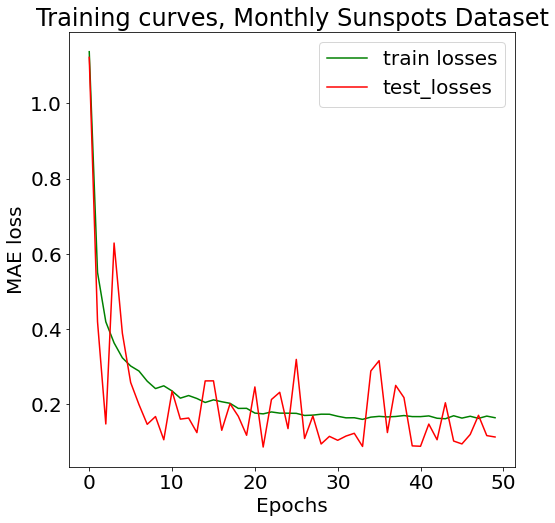

In [230]:
plt.figure(figsize = (8,8))

plt.plot(train_losses, label = 'train losses', color = 'green')
plt.plot(test_losses, label = 'test_losses', color = 'red')
plt.legend(loc = 'best')

plt.title('Training curves, Monthly Sunspots Dataset')

plt.xlabel('Epochs')
plt.ylabel('MAE loss')

plt.show()

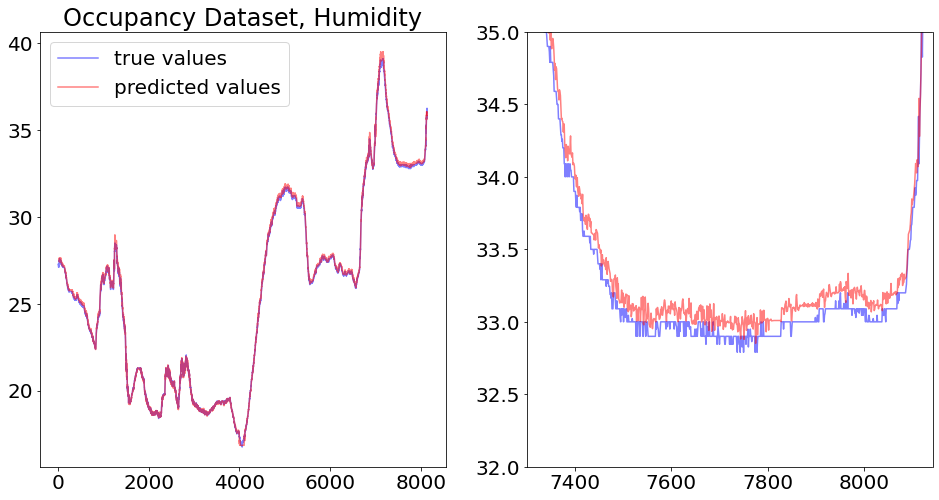

In [231]:
model.eval()
prediction_segment = torch.Tensor(train_test_data[0][:sizes[0]]).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()

val_prediction_segment = torch.Tensor(validation_data[0]).to(device)
val_absolute_prediction = model(val_prediction_segment).cpu().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize = (16, 8))
axes[0].plot(sync_data_hum, color = 'blue', label = 'true values', alpha = 0.5)
axes[0].plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
axes[0].plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
axes[0].set_title('Occupancy Dataset, Humidity')
axes[0].legend(loc = 'best')


axes[1].plot(sync_data_hum, color = 'blue', label = 'true values', alpha = 0.5)
axes[1].plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
axes[1].plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
#axes[1].set_title('Occupancy Dataset, Humidity')
axes[0].legend(loc = 'best')
axes[1].set_ylim(32, 35)
axes[1].set_xlim(7300, 8142)
plt.show()

# Кортикограммы

(3, 125374)


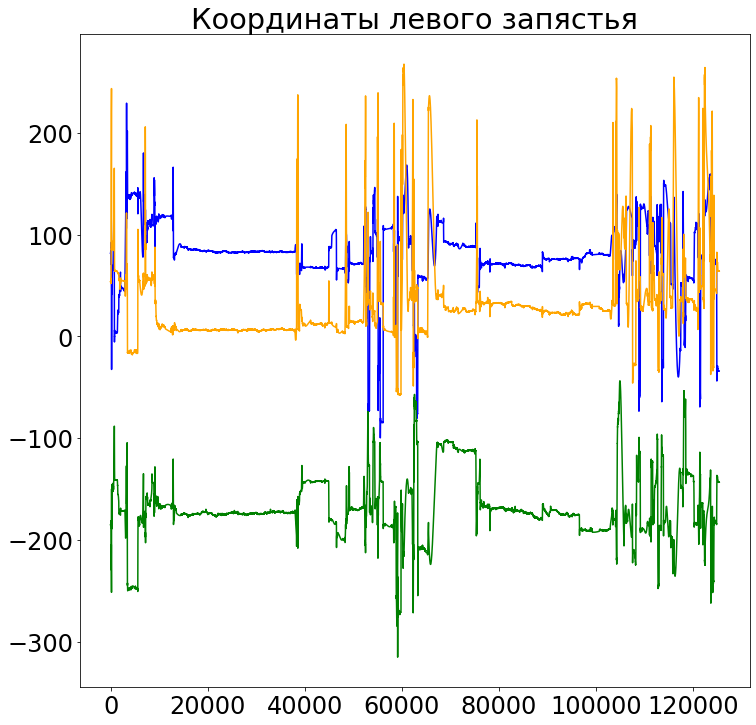

In [10]:
motion = loadmat('tracking_data/data/Motion.mat')

plt.rcParams.update({'font.size': 24})

case = 2

plt.figure(figsize = (12, 12))

plt.title('Координаты левого запястья')

x = motion['MotionData'][case][0][:, 0]
y = motion['MotionData'][case][0][:, 1]
z = motion['MotionData'][case][0][:, 2]

a = len(x)
#a = 10000

plt.plot(x[:a], label = 'x',color = 'blue')
plt.plot(y[:a], label = 'y',color = 'green')
plt.plot(z[:a], label = 'z', color = 'orange')

target_array = np.array([x,y,z])
print(target_array.shape)

_ = plt.savefig('Координаты.png')

plt.show()

In [11]:
pos_arr = (motion['MotionTime']*1e3).astype(int).flatten()

In [12]:
channel_data_array = []

for i in range(64):
    d = loadmat('tracking_data/data/ECoG_ch{}.mat'.format(i+1))['ECoGData_ch{}'.format(i+1)]
    channel_data_array.append(d[0])
    
channel_data_array = np.array(channel_data_array)

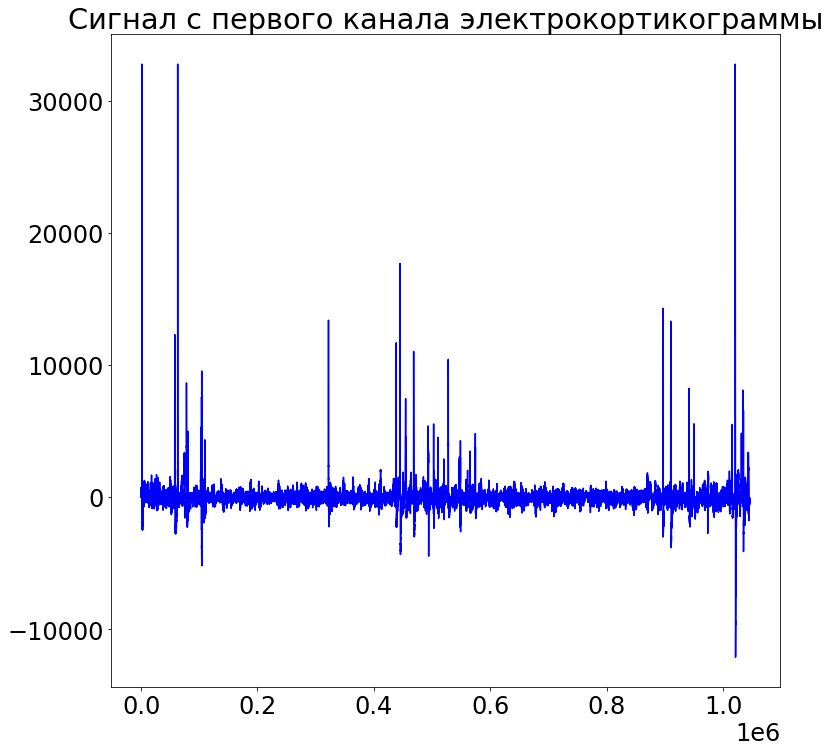

In [13]:
plt.figure(figsize = (12, 12))

plt.title('Сигнал с первого канала электрокортикограммы')

x = channel_data_array[0]

a = len(x)
#a = 10000

plt.plot(x[:a], label = 'x',color = 'blue')

target_array = np.array([x,y,z])

_ = plt.savefig('Сигнал.png')

plt.show()

In [99]:
#fake_target_array = np.zeros((3, channel_data_array.shape[1]))
#fake_target_array.shape

In [14]:
def generate_STON_based_dataset_for_multiple_series(channel_data_array, target_array, V_array_big, S_array_big,\
                                                    m, prediction_window = 1, u = 10, \
                                                    r = 0.1, A = 'default', L_1 = 5, L_2 = 10):
            
    print('Forming dataset...')
        
    train_test_data = combine_hyperfields_for_multiple_series(channel_data_array = channel_data_array, \
                                                                   target_array = target_array, \
                                                                   V_array_big = V_array_big, S_array_big = S_array_big,\
                                                                   L_1 = L_1, L_2 = L_2)
    return train_test_data



def generate_big_arrays(channel_data_array, target_array, m, prediction_window = 1, \
                                                    u = 10, r = 0.1, A = 'default', L_1 = 5, L_2 = 10):
    V_array_big = []
    S_array_big = []
    
    print('Generating multivectors...')
    for i in range(64):
        print('i = {}'.format(i))
        channel_data = channel_data_array[i]
        V_array = calculate_hyperfield_V(data = channel_data, m = m, prediction_window = prediction_window, u = u, r = r, A = A)
        S_array = calculate_emergent_hyperfields_S(V_array = V_array, L_1 = L_1, L_2 = L_2)
        V_array_big.append(V_array)
        S_array_big.append(S_array)
    
    return V_array_big, S_array_big


def target_func(data, index, w):
    return data.T[index]


def combine_hyperfields_for_multiple_series(channel_data_array, target_array, V_array_big, S_array_big, L_1 = 5, L_2 = 10):
    
    L = max(L_1, L_2)
    
    train_test_data_features = []
    train_test_data_targets = []
    
    sizes = []
    
    for k, arrays in enumerate(zip(V_array_big, S_array_big)):
        
        V_array, S_array = arrays
        
        features_full = []
        targets_full = []
        
        for i, arrs in enumerate(zip(V_array, S_array)):
            V_arr, S_arr = arrs
            w = i + 1
            features = []
            targets = []

            for j in range(L, len(V_arr[0])):
                features.append(np.array([np.sum(V_arr[0][j]),np.sum(S_arr[0][j]), np.sum(S_arr[1][j]), np.sum(S_arr[2][j])]))
                targets.append(target_func(target_array, V_arr[1][j], w))

            features_full.extend(features)
            targets_full.extend(targets)
            
            
                
        if (k == 0):        
            train_test_data_features = np.array(features_full)
        else:
            train_test_data_features = np.hstack((train_test_data_features, np.array(features_full)))
        if (k == 0):
            train_test_data_targets.extend(targets_full)
  
    return (np.array(train_test_data_features), np.array(train_test_data_targets))

In [15]:
def calculate_sparse_hyperfield_V(data, m, idx_arr, prediction_window = 1, u = 10, r = 0.1, A = 'default', extend = False, \
                                  include_time = True):
    
    if A == 'default':
        A = np.zeros((u, u))
        for i in range(u):
            for j in range(u):
                if i < j:
                    A[i][j] = 1
    
    elif A == 'circular':
        A = np.zeros((u, u))
        for i in range(u):
            if i < u - 1:
                A[i][i+1] = 1
            else:
                A[i][0] = 1
    
    
    centre_list = []
    for k in range(u):
        centre_list.append((cos(2*pi*k/u), sin(2*pi*k/u), 0))
    
    S_array = calculate_S_array(centre_list, r)
    
    V_final_array = []
    
    if extend == True:
        l = list(data)
        l.extend([0]*u)
        data = np.array(l)
    
    for w in range(1, prediction_window + 1):
        
        V_array = []
        if include_time:
            time_array = []
        
        if extend == False:
            modified_data = np.flip(data[np.arange(m + w, -1, -w)])
            original_index = np.flip(np.arange(len(data))[np.arange(m + w, -1, -w)])
        else:
            modified_data = np.flip(data[np.arange(m + 2*w, -1, -w)])
            original_index = np.flip(np.arange(len(data))[np.arange(m + 2*w, -1, -w)])
        
        for i in (idx_arr[idx_arr - u >= 0] - u):
            alpha = modified_data[i:(i+u)]
            Omega = np.array([alpha[i]*S_array[i] for i in range(u)])
            V_N = np.sum(Omega, axis = 0)
            V_AN = np.sum(np.array([[Omega[i]*Omega[j]*A[i][j] for j in range(u)] for i in range(u)]), axis = (0, 1, 2))
            V = np.hstack((V_N, V_AN))
            
            V_array.append(V)
            if include_time:
                time_array.append(original_index[i+u])
        
        if include_time:
            V_final_array.append((V_array, time_array))
        else:
            V_final_array.append(V_array)
        
    return V_final_array[0]

In [14]:
m = channel_data_array.shape[1] - 2

u = 50

features = []

for i, data in tqdm(enumerate(channel_data_array)):
    if i == 0:
        V = calculate_sparse_hyperfield_V(data, m, pos_arr, u = u, A = 'circular', include_time = False)
        features = np.array(V)
    else:
        V = calculate_sparse_hyperfield_V(data, m, pos_arr, u = u, A = 'circular', include_time = False)
        features = np.hstack((features, V))

features = np.array(features)

19it [8:28:11, 1604.83s/it]


KeyboardInterrupt: 

In [ ]:
features.shape

In [ ]:
np.save('features_50_simplified.npy', features)

In [71]:
#m = channel_data_array_cropped.shape[1] - 2

#V_array_big, S_array_big = generate_big_arrays(channel_data_array_cropped, fake_target_array_cropped, m, u = 25, A = 'circular')

In [74]:
#train_test_data = generate_STON_based_dataset_for_multiple_series(channel_data_array_cropped, fake_target_array_cropped, 
#                                                                  V_array_big, S_array_big, m)

In [75]:
#np.save('features_10_1_10.npy', train_test_data[0])

In [76]:
#np.save('targets_10.npy', train_test_data[1])

In [62]:
train_test_data_features = np.load('features_10_simplified.npy')
k = target_array.shape[1] - train_test_data_features.shape[0]
train_test_data_targets = target_array[:, k:].T
x, y, z = train_test_data_targets.T
print(x.shape)

train_test_data_targets = train_test_data_targets[:, 2].reshape(-1, 1)

print(train_test_data_features.shape)
print(train_test_data_targets.shape)

(125372,)
(125372, 384)
(125372, 1)


In [65]:
#train_test_data_targets = np.target

In [66]:
#x, y, z = train_test_data_targets.T

In [70]:
#m = len(x) - 2
#train_test_data_x, validation_data_x, _ = generate_STON_based_dataset_for_single_series(x, m, prediction_window = 1, u = 10, \
#                                                                                    r = 0.1, A = 'default', L_1 = 5, L_2 = 10)

In [68]:
#train_test_data_features = np.hstack((train_test_data_features, np.vstack((train_test_data_x[0],validation_data_x[0]))))

In [71]:
#train_test_data_y, validation_data_y, _ = generate_STON_based_dataset_for_single_series(y, m, prediction_window = 1, u = 10, \
#                                                                                    r = 0.1, A = 'default', L_1 = 5, L_2 = 10)

In [177]:
#train_test_data_features = np.hstack((train_test_data_features, np.vstack((train_test_data_y[0],validation_data_y[0]))))

In [72]:
#train_test_data_z, validation_data_z, _ = generate_STON_based_dataset_for_single_series(z, m, prediction_window = 1, u = 10, \
#                                                                                    r = 0.1, A = 'default', L_1 = 5, L_2 = 10)

In [178]:
#train_test_data_features = np.hstack((train_test_data_features, np.vstack((train_test_data_z[0],validation_data_z[0]))))

In [73]:
#train_test_data_features.shape

In [74]:
#train_test_data_targets.shape

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    

class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        # Stack some fully connected layers wirh relu activation.
        # Note that you do not have to add relu after the last fc layer
        
        model = []
        for i in range(len(hiddens)):
            if i == 0:
                model += [nn.Linear(input_shape, hiddens[i])]
            else:
                model += [nn.Linear(hiddens[i-1], hiddens[i])]
            model += [nn.ReLU()]
        
        model += [nn.Linear(hiddens[-1], output_shape)]
        self.net = nn.Sequential(*model)

    def forward(self, x):
        return self.net(x)

In [49]:
BATCH_SIZE = 64
EPOCHS =21
LR = 1e-4

In [63]:
scaler = StandardScaler()
scaled_train_test_data_features = scaler.fit_transform(train_test_data_features)

train_test_dataset = TimeSeriesDataset(scaled_train_test_data_features, train_test_data_targets)
#train_test_dataset = TimeSeriesDataset(train_test_data_features, train_test_data_targets)

train_size = int(0.75 * len(train_test_dataset))
test_size = len(train_test_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_test_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

In [25]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    
device = torch.device(device)

In [26]:
device

device(type='cuda', index=0)

In [17]:
def train_epoch(model, train_loader, optimizer, loss, verbose = False):
    model.train()
    losses_array = []
    for batch in tqdm(train_loader, disable = not verbose):
        x, y = batch
        losses = loss(model(x.float().to(device)), y.float().to(device))
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        losses_array.append(losses)
    return losses_array

def eval_model(model, test_loader, loss):
    model.eval()
    losses_array = []
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            losses = loss(model(x.float().to(device)), y.float().to(device))
            losses_array.append(losses)
            
    return losses_array


def train_model(model, train_loader, test_loader, batch_size, epochs, lr, verbose = False, extra_verbose = False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    loss = nn.L1Loss()

    train_losses = []
    test_losses = []
    
    i = 1
    
    for epoch in tqdm(range(epochs), disable = verbose):
        train_loss = train_epoch(model, train_loader, optimizer, loss = loss, verbose = extra_verbose)
        test_loss = eval_model(model, test_loader, loss = loss)
        
        if (verbose == True):
            print('Epoch {}: Test loss = {}'.format(i, torch.Tensor(test_loss).mean().cpu().detach().numpy()))
        
        i += 1
        
        train_losses.append(torch.Tensor(train_loss).cpu().detach().numpy().mean())
        test_losses.append(torch.Tensor(test_loss).cpu().detach().numpy().mean())

        scheduler.step()
    return np.array(train_losses), np.array(test_losses)

In [64]:
model = FullyConnectedMLP(384, [512, 1024, 512, 256, 128], 1).to(device)
train_losses, test_losses = train_model(model, train_loader, test_loader, batch_size = BATCH_SIZE, epochs = EPOCHS, lr = LR, \
                                       verbose = True)

Epoch 1: Test loss = 4.772634983062744
Epoch 2: Test loss = 5.397505283355713
Epoch 3: Test loss = 3.8060848712921143
Epoch 4: Test loss = 4.352791786193848
Epoch 5: Test loss = 3.6005992889404297
Epoch 6: Test loss = 3.4769651889801025
Epoch 7: Test loss = 3.083921194076538
Epoch 8: Test loss = 3.478088140487671
Epoch 9: Test loss = 3.994572877883911
Epoch 10: Test loss = 3.4009506702423096
Epoch 11: Test loss = 2.628819227218628
Epoch 12: Test loss = 2.535306215286255
Epoch 13: Test loss = 2.5576019287109375
Epoch 14: Test loss = 2.5034804344177246
Epoch 15: Test loss = 2.2930779457092285
Epoch 16: Test loss = 2.7864561080932617
Epoch 17: Test loss = 2.650439500808716
Epoch 18: Test loss = 2.2164669036865234
Epoch 19: Test loss = 2.4743218421936035
Epoch 20: Test loss = 2.9418880939483643
Epoch 21: Test loss = 2.0332789421081543


In [154]:
#results = []

In [190]:
results.append([train_losses, test_losses])

In [87]:
model.eval()
prediction_segment = torch.Tensor(scaled_train_test_data_features).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()

In [192]:
#predictions = []
predictions.append(absolute_prediction)

In [210]:


pearsonr(x = [1, 2, 3], y = [2, 4, 6])

(0.9999999999999998, 1.3415758552508151e-08)

In [221]:
target = train_test_data_targets[20:]
mse = []
mae = []
pearson = []
for pred in predictions:
    mse.append(np.mean((target - pred)**2))
    mae.append(np.mean(np.abs(target - pred)))
    pearson.append(pearsonr(x = target.flatten(), y = pred.flatten())[0])

In [222]:
print(np.array(mse).mean())
print(np.array(mse).std())

5.209607778182354
0.8610618107188326


In [223]:
print(np.array(mae).mean())
print(np.array(mae).std())

0.7674816347608978
0.16195805257119342


In [224]:
print(np.array(pearson).mean())
print(np.array(pearson).std())

0.9998087808477335
3.3906049215172983e-05


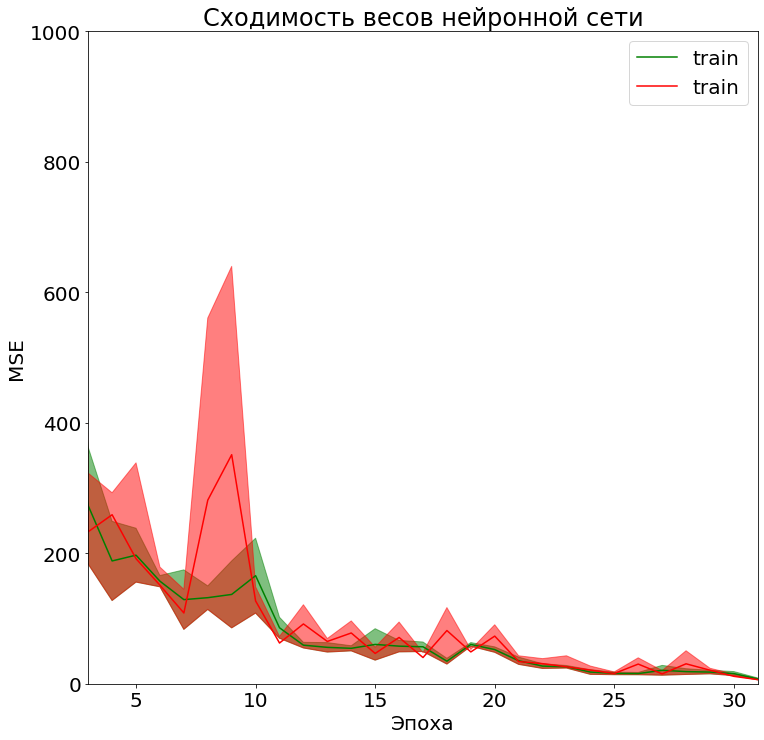

In [207]:
e1, e2, e3 = results
train = np.array([e1[0], e2[0], e3[0]])
test = np.array([e1[1], e2[1], e3[1]])
mean_tr = train.mean(axis = 0)
std_tr = train.std(axis = 0)

mean_test = test.mean(axis = 0)
std_test = test.std(axis = 0)

plt.figure(figsize = (12, 12))
plt.title('Сходимость весов нейронной сети')

l = np.arange(1, 32)
plt.plot(l, mean_tr, label = 'train', color = 'green')
plt.fill_between(l, mean_tr + std_tr, mean_tr - std_tr, color = 'green', alpha = 0.5)

plt.plot(l, mean_test, label = 'train', color = 'red')
plt.fill_between(l, mean_test + std_test, mean_tr - std_tr, color = 'red', alpha = 0.5)
plt.legend(loc = 'best')

plt.ylim(0, 1000)
plt.ylabel('MSE')
plt.xlabel('Эпоха')
plt.xlim(3, 31)
plt.show()

In [54]:
absolute_prediction.shape

(12534, 3)

In [55]:
x, y, z = train_test_data_targets.T
x.shape

(12534,)

In [56]:
model.eval()
prediction_segment = torch.Tensor(scaled_train_test_data_features).to(device)
#prediction_segment = torch.Tensor(train_test_data_features).to(device)
absolute_prediction_x = model(prediction_segment).cpu().detach().numpy()

In [61]:
model.eval()
prediction_segment = torch.Tensor(scaled_train_test_data_features).to(device)
#prediction_segment = torch.Tensor(train_test_data_features).to(device)
absolute_prediction_y = model(prediction_segment).cpu().detach().numpy()

In [65]:
model.eval()
prediction_segment = torch.Tensor(scaled_train_test_data_features).to(device)
#prediction_segment = torch.Tensor(train_test_data_features).to(device)
absolute_prediction_z = model(prediction_segment).cpu().detach().numpy()

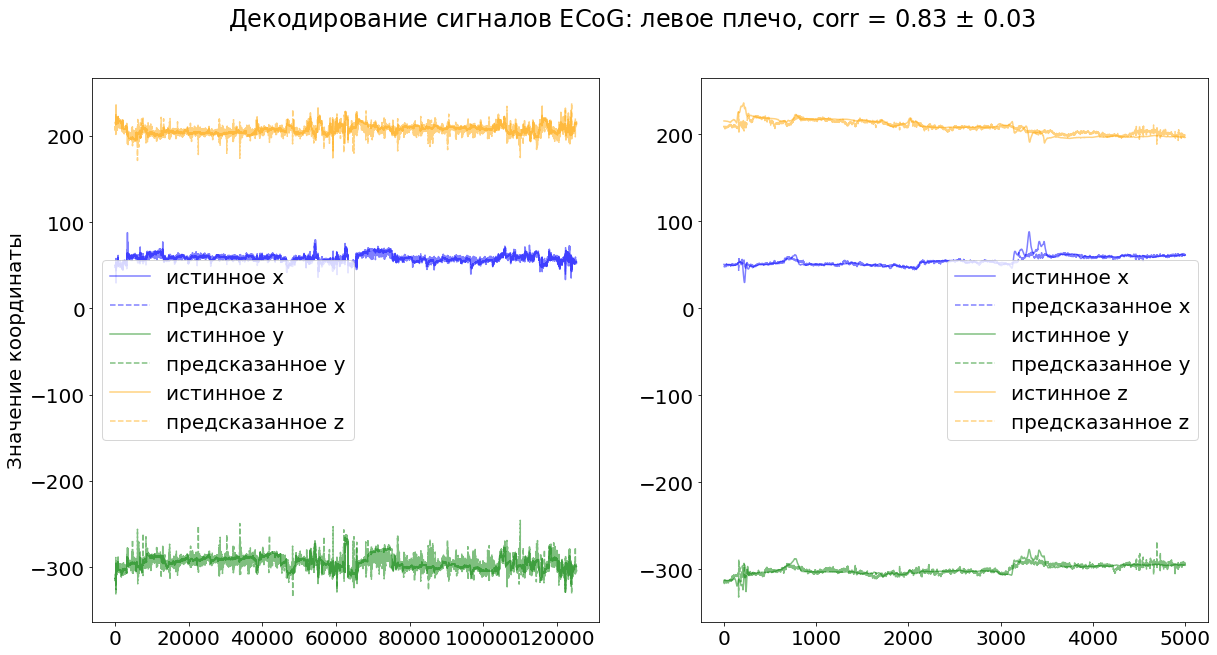

In [80]:
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(1, 2, figsize = (20, 10))

x_pears = pearsonr(x, absolute_prediction_x[:, 0])[0]
y_pears = pearsonr(y, absolute_prediction_y[:, 0])[0]
z_pears = pearsonr(z, absolute_prediction_z[:, 0])[0]

pears = np.array([x_pears, y_pears, z_pears])
m = np.mean(pears)
std = np.std(pears)


fig.suptitle('Декодирование сигналов ECoG: левое плечо, corr = {} $ \pm $ {}'.format(round(m, 2), round(std, 2)))


a = x.shape[0]
#a = 10000


axes[0].plot(x[:a], label = 'истинное x', color = 'blue', alpha = 0.5)
axes[0].plot(absolute_prediction_x[:a], '--', label = 'предсказанное x', color = 'blue', alpha = 0.5)
axes[0].plot(y[:a], color = 'green', label = 'истинное y', alpha = 0.5)
axes[0].plot(absolute_prediction_y[:a], '--', color = 'green', label = 'предсказанное y', alpha = 0.5)
axes[0].plot(z[:a], color = 'orange', label = 'истинное z', alpha = 0.5)
axes[0].plot(absolute_prediction_z[:a], '--', color = 'orange', label = 'предсказанное z', alpha = 0.5)
axes[0].legend(loc = 'best')

axes[0].set_ylabel('Значение координаты')

#a = x.shape[0]
a = 5000


axes[1].plot(x[:a], label = 'истинное x', color = 'blue', alpha = 0.5)
axes[1].plot(absolute_prediction_x[:a], '--', label = 'предсказанное x', color = 'blue', alpha = 0.5)
axes[1].plot(y[:a], color = 'green', label = 'истинное y', alpha = 0.5)
axes[1].plot(absolute_prediction_y[:a], '--', color = 'green', label = 'предсказанное y', alpha = 0.5)
axes[1].plot(z[:a], color = 'orange', label = 'истинное z', alpha = 0.5)
axes[1].plot(absolute_prediction_z[:a], '--', color = 'orange', label = 'предсказанное z', alpha = 0.5)
axes[1].legend(loc = 'best')

plt.show()

In [29]:
def run_experiment(case, u, title):
    
    BATCH_SIZE = 64
    EPOCHS = 21
    LR = 1e-4
    
    #if torch.cuda.is_available():
    #    device = "cuda:0"
    #else:
    #    device = "cpu"
    
    #device = torch.device(device)
    #print(device)
    
    motion = loadmat('tracking_data/data/Motion.mat')

    x_original = motion['MotionData'][case][0][:, 0]
    y_original = motion['MotionData'][case][0][:, 1]
    z_original = motion['MotionData'][case][0][:, 2]

    target_array = np.array([x_original,y_original,z_original])

    
    train_test_data_features = np.load('features_{}_simplified.npy'.format(u))
    k = target_array.shape[1] - train_test_data_features.shape[0]
    train_test_data_targets = target_array[:, k:].T
    x, y, z = train_test_data_targets.T
    
    absolute_prediction = []
    
    for target in (x, y, z):
        train_test_data_targets = target.reshape(-1, 1)

        scaler = StandardScaler()
        scaled_train_test_data_features = scaler.fit_transform(train_test_data_features)

        train_test_dataset = TimeSeriesDataset(scaled_train_test_data_features, train_test_data_targets)
        #train_test_dataset = TimeSeriesDataset(train_test_data_features, train_test_data_targets)

        train_size = int(0.75 * len(train_test_dataset))
        test_size = len(train_test_dataset) - train_size

        train_dataset, test_dataset = torch.utils.data.random_split(train_test_dataset, [train_size, test_size])

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)
        
        model = FullyConnectedMLP(384, [512, 1024, 512, 256, 128], 1).to(device)
        train_losses, test_losses = train_model(model, train_loader, test_loader, batch_size = BATCH_SIZE, epochs = EPOCHS, lr = LR, \
                                       verbose = False)
        
        model.eval()
        prediction_segment = torch.Tensor(scaled_train_test_data_features).to(device)
        #prediction_segment = torch.Tensor(train_test_data_features).to(device)
        pred = model(prediction_segment).cpu().detach().numpy().flatten()
        absolute_prediction.append(pred)
        
    absolute_prediction = np.array(absolute_prediction).T
    
    x_pears = pearsonr(x, absolute_prediction[:, 0])[0]
    y_pears = pearsonr(y, absolute_prediction[:, 1])[0]
    z_pears = pearsonr(z, absolute_prediction[:, 2])[0]
    
    pears = np.array([x_pears, y_pears, z_pears])
    m = np.mean(pears)
    std = np.std(pears)

    fig, axes = plt.subplots(1, 1, figsize = (20, 10))

    #fig.suptitle('Декодирование сигналов ECoG: {}, corr = {} $ \pm $ {}'.format(title, round(m, 2), round(std, 2)))


    a = x.shape[0]
    #a = 10000


    axes.plot(x[:a], label = 'истинное x', color = 'blue')
    axes.plot(absolute_prediction[:a, 0], '--', label = 'предсказанное x', color = 'blue', alpha = 0.5)
    axes.plot(y[:a], color = 'green', label = 'истинное y')
    axes.plot(absolute_prediction[:a, 1], '--', color = 'green', label = 'предсказанное y', alpha = 0.5)
    axes.plot(z[:a], color = 'orange', label = 'истинное z')
    axes.plot(absolute_prediction[:a, 2], '--', color = 'orange', label = 'предсказанное z', alpha = 0.5)
    axes.legend(loc = 'best')

    axes.set_ylabel('Значение координаты')

    #a = x.shape[0]
    #a = 5000


    #axes[1].plot(x[:a], label = 'истинное x', color = 'blue', alpha = 0.5)
    #axes[1].plot(absolute_prediction[:a, 0], '--', label = 'предсказанное x', color = 'blue', alpha = 0.5)
    #axes[1].plot(y[:a], color = 'green', label = 'истинное y', alpha = 0.5)
    #axes[1].plot(absolute_prediction[:a, 1], '--', color = 'green', label = 'предсказанное y', alpha = 0.5)
    #axes[1].plot(z[:a], color = 'orange', label = 'истинное z', alpha = 0.5)
    #axes[1].plot(absolute_prediction[:a, 2], '--', color = 'orange', label = 'предсказанное z', alpha = 0.5)
    #axes[1].legend(loc = 'best')
    
    _ = plt.savefig('{}_{}.png'.format(title, u))

    plt.show()
    
    print('corr = {} $ \pm $ {}'.format(round(m, 2), round(std, 2)))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:03<00:00,  5.87s/it]


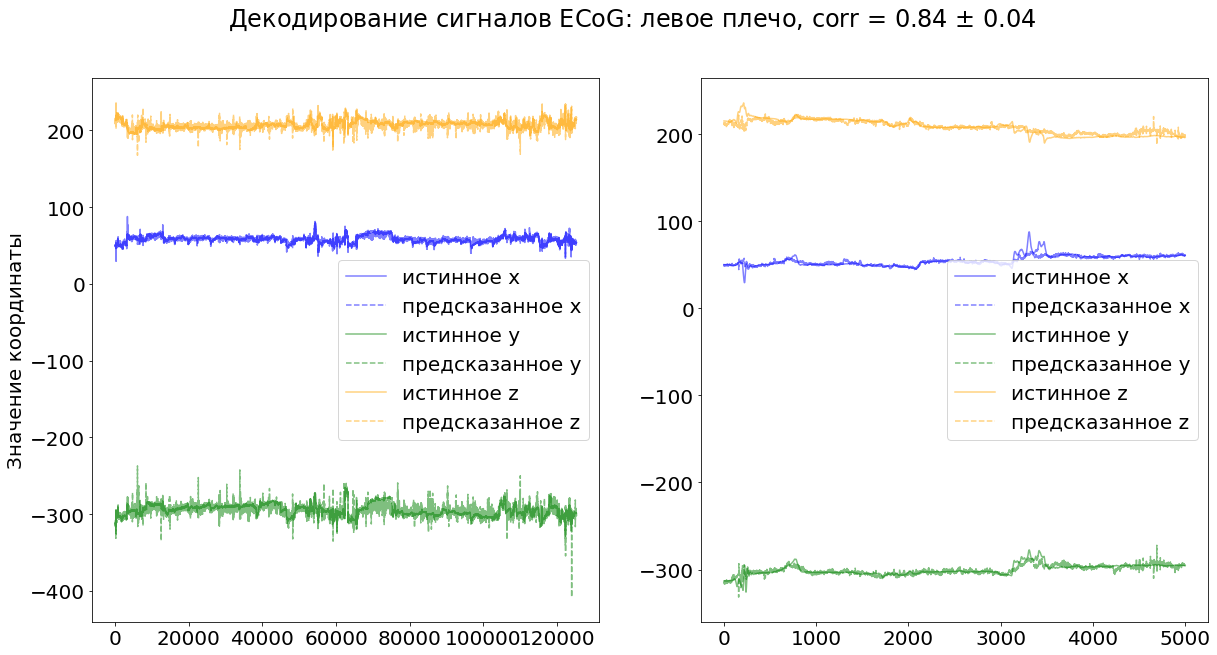

In [88]:
run_experiment(0, 10, 'левое плечо')

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:04<00:00,  5.94s/it]


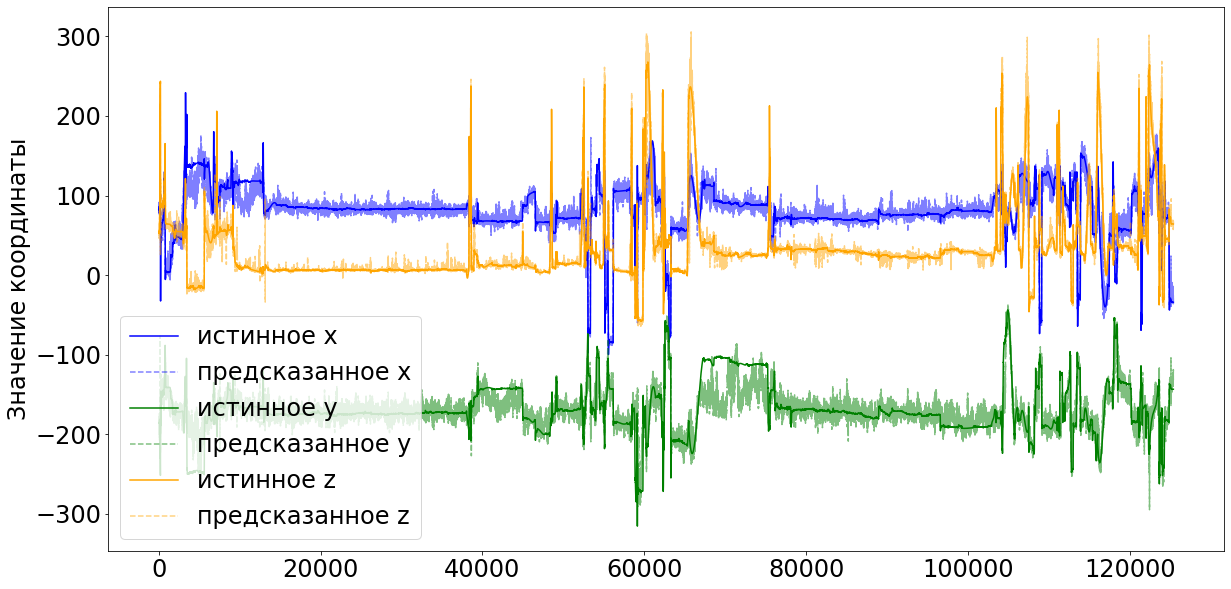

corr = 0.91 $ \pm $ 0.06


In [30]:
arr = [(0, 'левое_плечо'), (1, 'левый_локоть'), (2, 'левое_запястье'), \
       (3, 'правое_плечо'), (4, 'правый_локоть'), (5, 'правое_запястье')]

for case, title in [arr[2]]:
    run_experiment(case, 25, title)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:01<00:00,  5.78s/it]


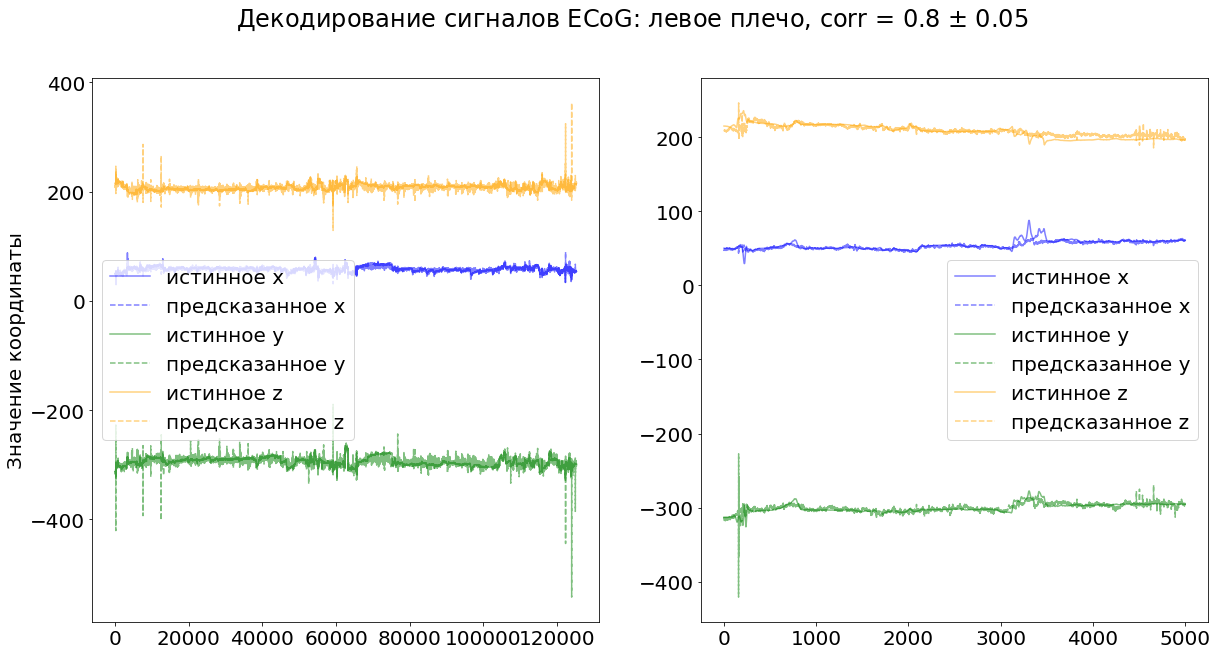

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:06<00:00,  6.03s/it]


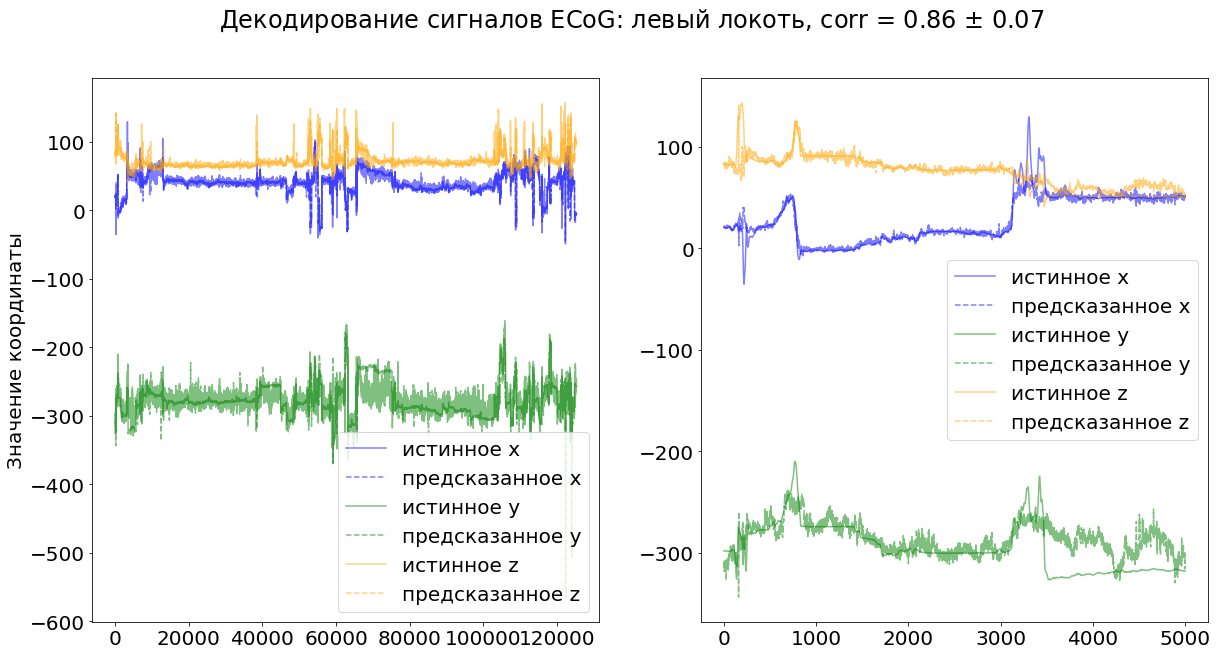

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:06<00:00,  6.02s/it]


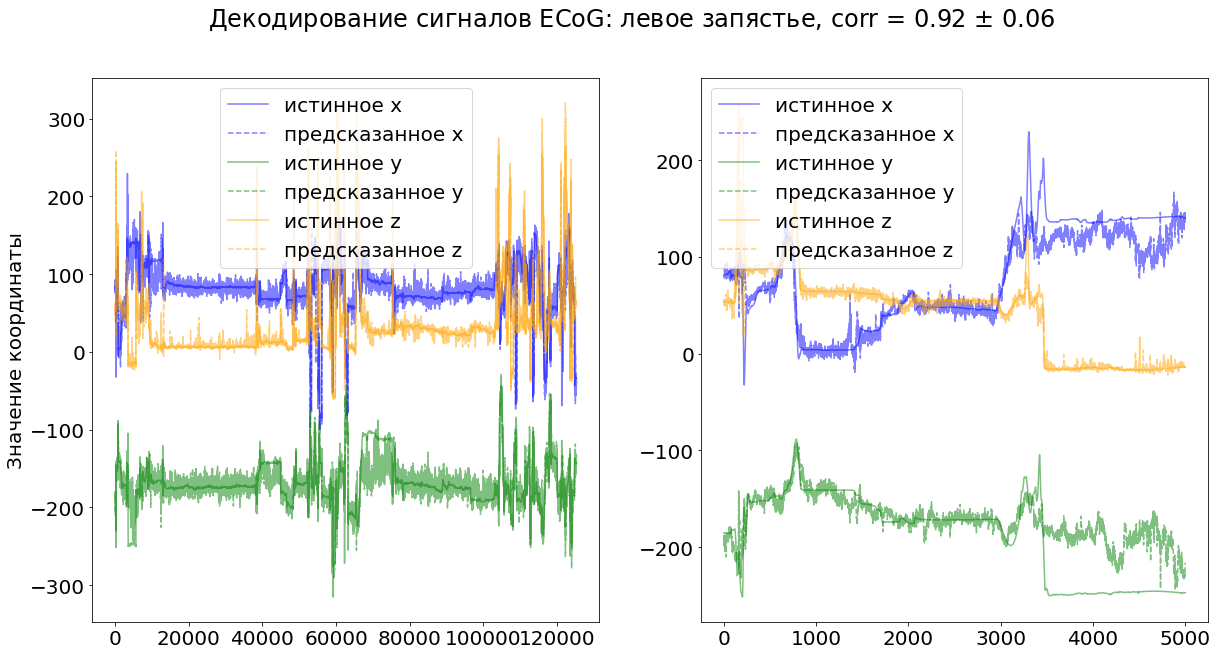

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:05<00:00,  5.99s/it]


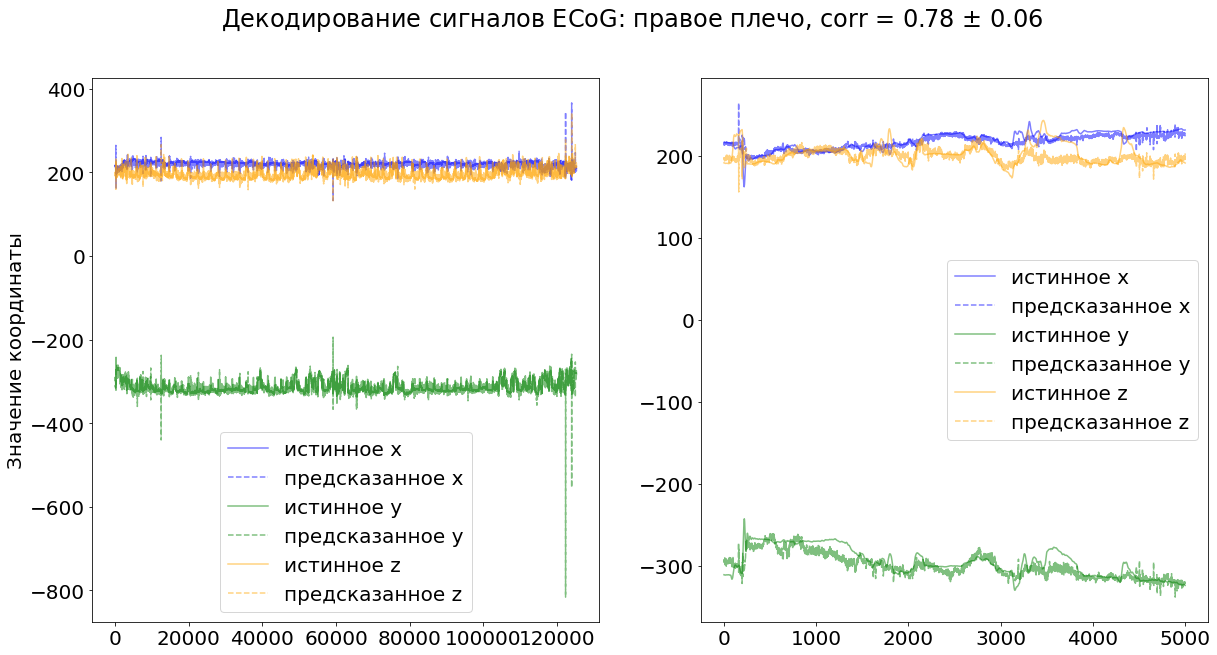

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:02<00:00,  5.83s/it]


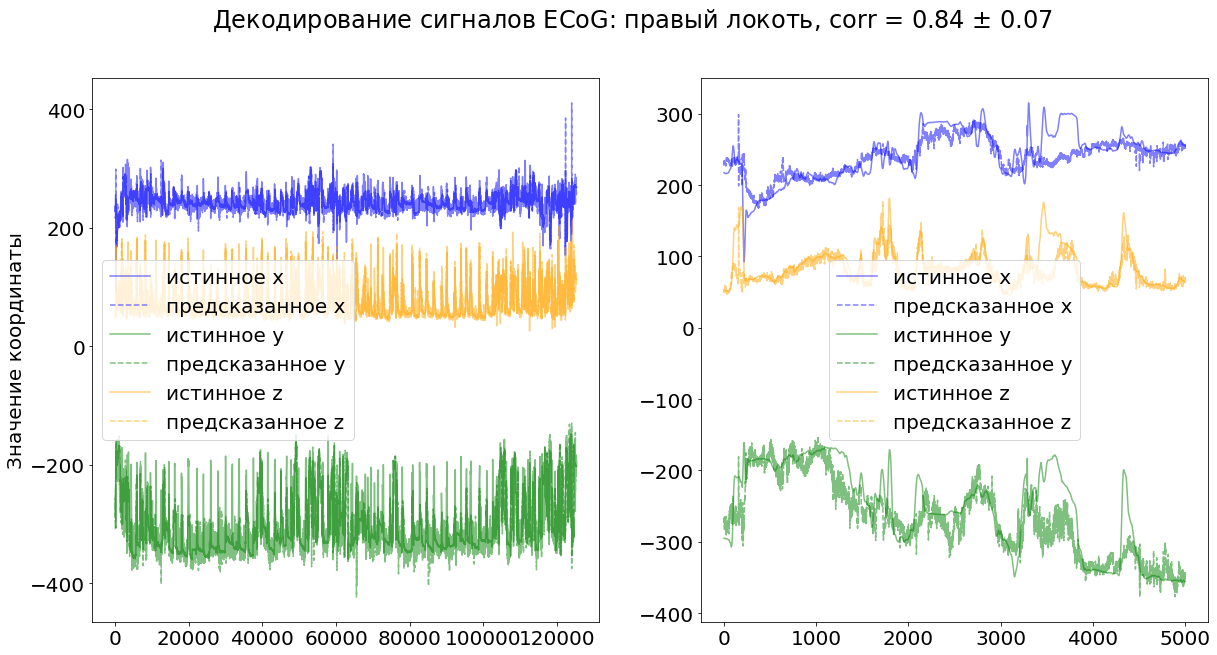

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:06<00:00,  6.02s/it]


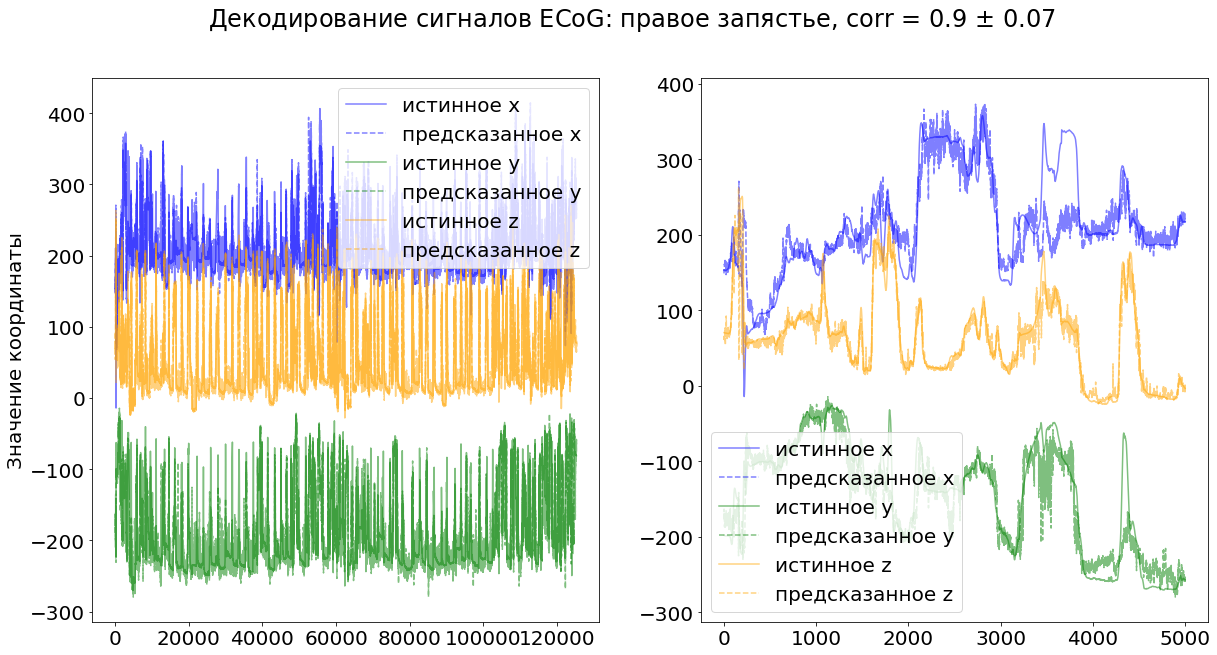

In [91]:
arr = [(0, 'левое плечо'), (1, 'левый локоть'), (2, 'левое запястье'), \
       (3, 'правое плечо'), (4, 'правый локоть'), (5, 'правое запястье')]

for case, title in arr:
    run_experiment(case, 25, title)

In [71]:
absolute_prediction_x.shape

(125372, 1)

In [72]:
x_pears = pearsonr(x, absolute_prediction_x[:, 0])[0]
y_pears = pearsonr(y, absolute_prediction_y[:, 0])[0]
z_pears = pearsonr(z, absolute_prediction_z[:, 0])[0]
print(x_pears)
print(y_pears)
print(z_pears)

0.8766979380497827
0.8072680022198648
0.8126387974990033


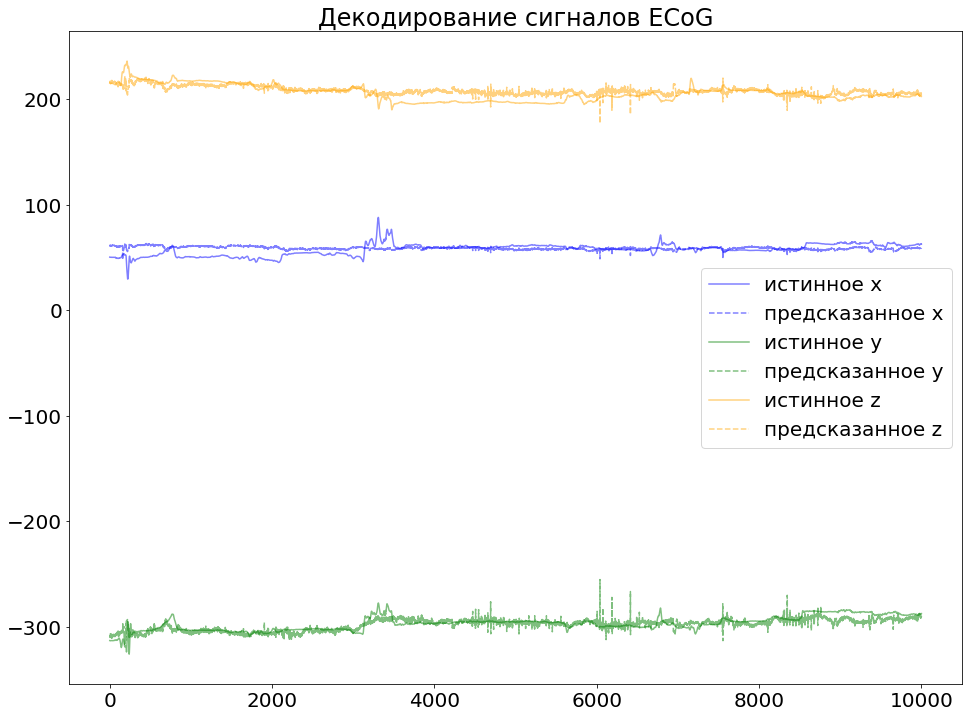

-0.18290706111725838
0.6837733225605568
0.6055532786277038


In [52]:
model.eval()
#prediction_segment = torch.Tensor(scaled_train_test_data_features).to(device)
prediction_segment = torch.Tensor(train_test_data_features).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()

x_pears = pearsonr(x, absolute_prediction[:, 0])[0]
y_pears = pearsonr(y, absolute_prediction[:, 1])[0]
z_pears = pearsonr(z, absolute_prediction[:, 2])[0]


plt.figure(figsize = (16, 12))

#a = x.shape[0]
a = 10000

plt.rcParams.update({'font.size': 20})

plt.plot(x[:a], label = 'истинное x', color = 'blue', alpha = 0.5)
plt.plot(absolute_prediction[:a, 0], '--', label = 'предсказанное x', color = 'blue', alpha = 0.5)
plt.plot(y[:a], color = 'green', label = 'истинное y', alpha = 0.5)
plt.plot(absolute_prediction[:a, 1], '--', color = 'green', label = 'предсказанное y', alpha = 0.5)
plt.plot(z[:a], color = 'orange', label = 'истинное z', alpha = 0.5)
plt.plot(absolute_prediction[:a, 2], '--', color = 'orange', label = 'предсказанное z', alpha = 0.5)

plt.title('Декодирование сигналов ECoG')

#plt.ylim(-40, 240)

plt.legend(loc = 'best')
plt.show()

print(x_pears)
print(y_pears)
print(z_pears)

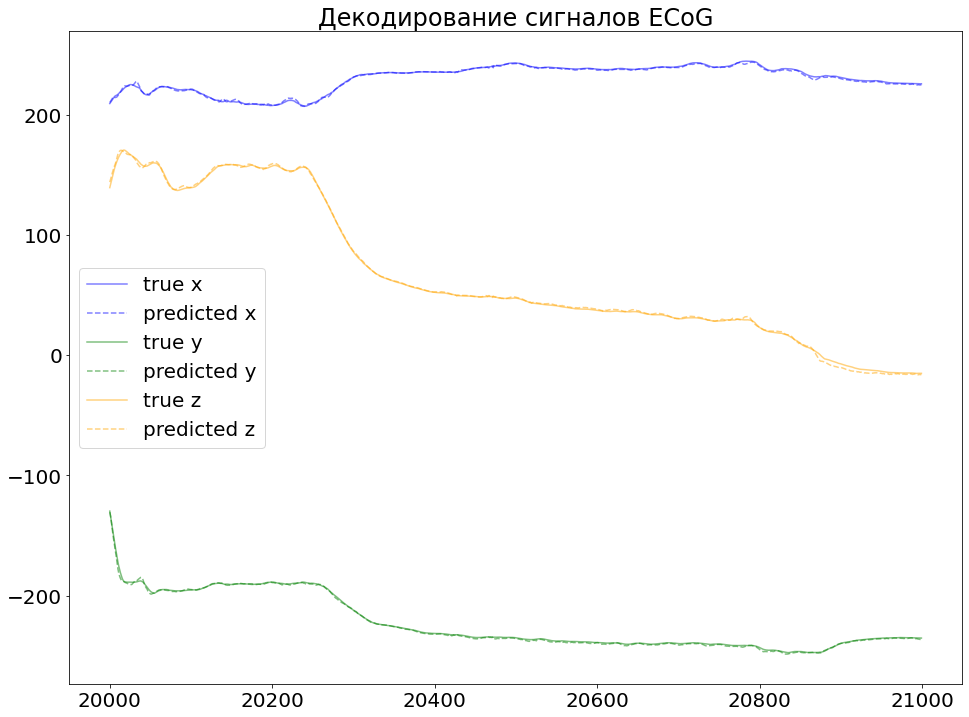

In [87]:
plt.figure(figsize = (16, 12))

l = np.arange(20000, 21000)

plt.plot(l, x[20000:21000], label = 'true x', color = 'blue', alpha = 0.5)
plt.plot(l, absolute_prediction[20000:21000, 0], '--', label = 'predicted x', color = 'blue', alpha = 0.5)
plt.plot(l, y[20000:21000], color = 'green', label = 'true y', alpha = 0.5)
plt.plot(l ,absolute_prediction[20000:21000, 1], '--', color = 'green', label = 'predicted y', alpha = 0.5)
plt.plot(l, z[20000:21000], color = 'orange', label = 'true z', alpha = 0.5)
plt.plot(l, absolute_prediction[20000:21000, 2], '--', color = 'orange', label = 'predicted z', alpha = 0.5)
plt.title('Декодирование сигналов ECoG')

plt.legend(loc = 'best')
plt.show()

In [160]:
train_test_data_features_yy = np.hstack((np.vstack((train_test_data_x[0],validation_data_x[0])), \
                                         np.vstack((train_test_data_y[0],validation_data_y[0])), \
                                         np.vstack((train_test_data_z[0],validation_data_z[0]))))

In [163]:
scaler_yy = StandardScaler()
scaled_train_test_data_features_yy = scaler_yy.fit_transform(train_test_data_features_yy)

train_test_dataset_yy = TimeSeriesDataset(scaled_train_test_data_features_yy, train_test_data_targets[20:])

train_size = int(0.75 * len(train_test_dataset_yy))
test_size = len(train_test_dataset_yy) - train_size

train_dataset_yy, test_dataset_yy = torch.utils.data.random_split(train_test_dataset_yy, [train_size, test_size])

train_loader_yy = DataLoader(train_dataset_yy, batch_size=BATCH_SIZE, shuffle = True)
test_loader_yy = DataLoader(test_dataset_yy, batch_size=BATCH_SIZE, shuffle = True)

In [164]:
EPOCHS = 6
model_yy = FullyConnectedMLP(12, [512, 1024, 512, 256], 3).to(device)
train_losses_yy, test_losses_yy = train_model(model_yy, train_loader_yy, test_loader_yy, batch_size = BATCH_SIZE, \
                                              epochs = EPOCHS, lr = LR, verbose = True)

Epoch 1: Test loss = 37.23310089111328
Epoch 2: Test loss = 42.254676818847656
Epoch 3: Test loss = 29.63042640686035
Epoch 4: Test loss = 9.453939437866211
Epoch 5: Test loss = 9.519353866577148
Epoch 6: Test loss = 9.033164024353027


In [165]:
model_yy.eval()
prediction_segment_yy = torch.Tensor(scaled_train_test_data_features_yy).to(device)
absolute_prediction_yy = model_yy(prediction_segment_yy).cpu().detach().numpy()

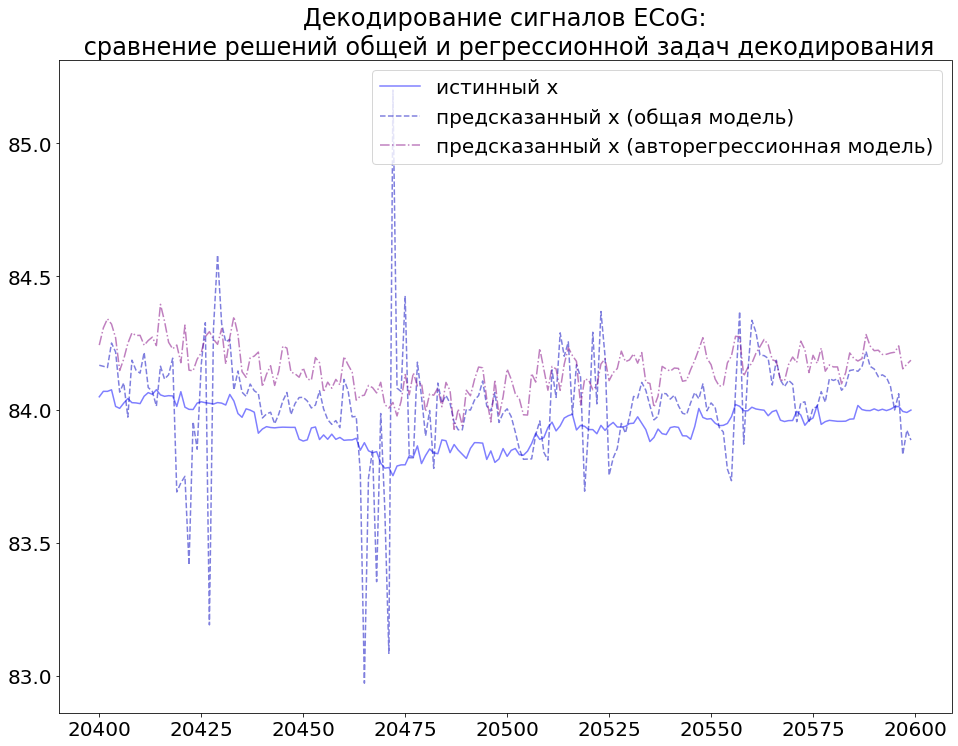

In [169]:
plt.figure(figsize = (16, 12))

a = 20400
b = 20600

l = np.arange(a, b)

plt.plot(l, x[a:b], label = 'истинный x', color = (0,0,1), alpha = 0.5)
plt.plot(l, absolute_prediction[a:b, 0], '--', label = 'предсказанный x (общая модель)', color = (0,0,0.75), alpha = 0.5)
plt.plot(l, absolute_prediction_yy[a:b, 0], '-.', label = 'предсказанный x (авторегрессионная модель)', color = (0.5,0,0.5), alpha = 0.5)

#plt.plot(l, y[a:b], color = 'green', label = 'true y', alpha = 0.5)
#plt.plot(l ,absolute_prediction_yy[a:b, 1], '--', color = 'green', label = 'predicted y', alpha = 0.5)
#plt.plot(l, z[a:b], color = 'orange', label = 'true z', alpha = 0.5)
#plt.plot(l, absolute_prediction_yy[a:b, 2], '--', color = 'orange', label = 'predicted z', alpha = 0.5)
plt.title('Декодирование сигналов ECoG:\n сравнение решений общей и регрессионной задач декодирования')

plt.legend(loc = 'best')
plt.show()

In [110]:
m = len(channel_data_array[0]) - 2

V_array_big_20, S_array_big_20 = generate_big_arrays(channel_data_array, target_array, m, u = 20)

Generating multivectors...
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7


KeyboardInterrupt: 